# Machine Learning

In previous part we got optimal adjustments for our model. So now we going to apply them to predict indicators of air quality for the next day 

In [ ]:
#install and import libraries
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
# from sklearn.multioutput import RegressorChain
# from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
# from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import glob
from catboost import CatBoostRegressor, Pool

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Shabolovka St.

In [ ]:
#load the stations's data
shab = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Moscow_contest/shab.csv', decimal=',')
shab = shab.set_index('data_time')
shab.head()

Unnamed: 0    CO  ... OutsideTemperature Quality
data_time                              ...                           
01/01/2020 00:00:00           0  0.21  ...               1.79     0.0
01/01/2020 00:20:00           1   0.2  ...               1.85     0.0
01/01/2020 00:40:00           2  0.19  ...               1.85     0.0
01/01/2020 01:00:00           3  0.19  ...               1.81     0.0
01/01/2020 01:20:00           4   0.2  ...               1.71     0.0

[5 rows x 26 columns]

In [ ]:
shab.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26353 entries, 01/01/2020 00:00:00 to 01/01/2021 00:00:00
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          26353 non-null  int64  
 1   CO                  24370 non-null  object 
 2   NO2                 25288 non-null  object 
 3   NO                  25287 non-null  object 
 4   PM10                24752 non-null  object 
 5   -T-                 25049 non-null  object 
 6   | V |               25051 non-null  object 
 7   _V_                 25051 non-null  object 
 8   Давление            25051 non-null  object 
 9   Влажность           25051 non-null  object 
 10  Осадки              25051 non-null  object 
 11  0                   25673 non-null  float64
 12  50                  25673 non-null  float64
 13  100                 25673 non-null  float64
 14  150                 25673 non-null  float64
 15  200                 25673 

In [ ]:
#convert object data to numeric
def to_numeric(data):
  data = data.copy()
  s = (data.dtypes == 'object')
  object_cols = s[s].index
  for col in object_cols:
    data[col] = data[col].astype('float')
  return data

In [ ]:
# run data preprocessing
def preprocessing(data):
  data = data.copy()
  garbage_cols = [col for col in data.columns if ('Unnamed' in col)]
  data = data.drop(garbage_cols, axis=1)
  data.index = pd.to_datetime(data.index)
  data = data.sort_index()
  data = data.resample('1H').sum()
  data = data.rename({'Давление': 'pressure'}, axis=1)
  data = data.rename({'Влажность': 'humidity'}, axis=1)
  data = data.rename({'Осадки': 'precipitation'}, axis=1)
  return data

In [ ]:
# select target columns
def get_target(data):
  target_cols = set(data.columns).intersection(set(['CO', 'NO2', 'NO', 'PM10', 'PM2.5', 'PM25']))
  return list(target_cols)

In [ ]:
# clean the dataset
data_clear = to_numeric(shab)
data_clear = preprocessing(data_clear)
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8785 entries, 2020-01-01 00:00:00 to 2021-01-01 00:00:00
Freq: H
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CO                  8785 non-null   float64
 1   NO2                 8785 non-null   float64
 2   NO                  8785 non-null   float64
 3   PM10                8785 non-null   float64
 4   -T-                 8785 non-null   float64
 5   | V |               8785 non-null   float64
 6   _V_                 8785 non-null   float64
 7   pressure            8785 non-null   float64
 8   humidity            8785 non-null   float64
 9   precipitation       8785 non-null   float64
 10  0                   8785 non-null   float64
 11  50                  8785 non-null   float64
 12  100                 8785 non-null   float64
 13  150                 8785 non-null   float64
 14  200                 8785 non-null   float64
 15  250        

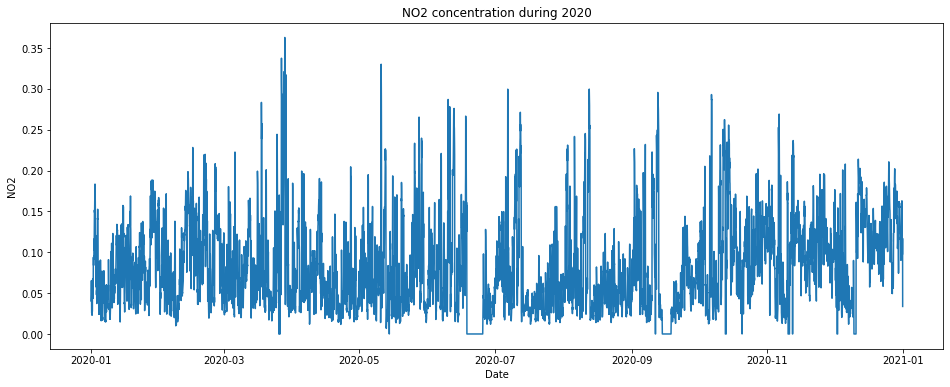

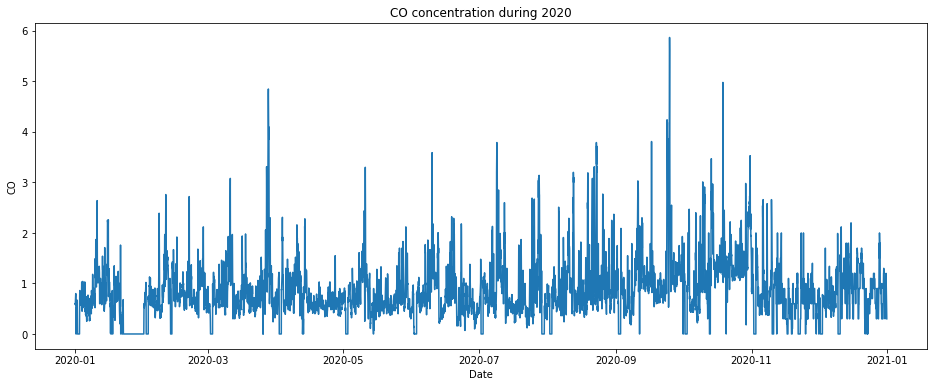

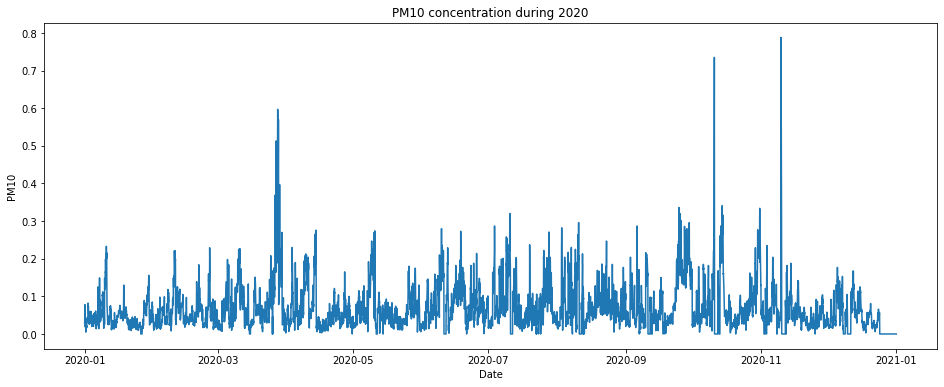

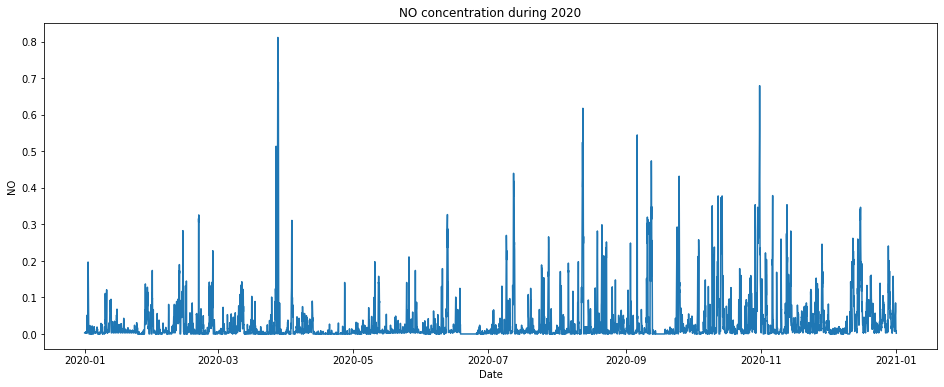

In [ ]:
# have a look at the targets
def plot_targets(data):
  for col in get_target(data):
      plt.figure(figsize=(16,6))
      plt.title("{} concentration during 2020".format(col))
      sns.lineplot(data=data[col])    
      plt.xlabel("Date")
      plt.ylabel(col)

plot_targets(data_clear)

In [ ]:
#extract components of date, moving average, moving standard deviation for each indicators, sesonality and trend for one of them (CO)
def make_features(data, max_lag, moving_average_size):
  data_new = data.copy()
  data_new['year'] = data_new.index.year
  data_new['month'] = data_new.index.month
  data_new['day'] = data_new.index.day
  data_new['dayofweek'] = data_new.index.dayofweek

  for col in get_target(data):
    data_new['moving_average_{}'.format(col)] = data_new[col].shift().rolling(moving_average_size).mean()
    data_new['std_{}'.format(col)] = data_new[col].shift().rolling(moving_average_size).std()

    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format([col, lag])] = data_new[col].shift(lag)
  
  decomposed = seasonal_decompose(data_new['CO'])
  data_new['seasonality'] = decomposed.seasonal.shift()
  data_new['trend'] = decomposed.trend.shift()
  
  return data_new

In [ ]:
#define a mean absolute percentage error and a symmetric mean absolute percentage error metrics
def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def mape(A, F):
    return (abs((A-F) / A)).median()

In [ ]:
#split data, fit model, run cross-validation and make prediction
def training_and_prediction(data):
  data_clear = data.copy()
  data_clear = make_features(data_clear, 350, 180)

  data_clear = data_clear.dropna()

  #brake data into train and test datasets
  train, test = data_clear.loc[:'31/12/2020 00:00:00'], data_clear.loc['31/12/2020 00:00:00':]

  target_train = train[get_target(data_clear)]
  features_train = train.drop(get_target(data_clear), axis=1) 
  target_test = test[get_target(data_clear)]
  features_test = test.drop(get_target(data_clear), axis=1) 

  model = MultiOutputRegressor(CatBoostRegressor(iterations=50, 
                            depth=3, 
                            learning_rate=0.3, 
                            loss_function='MAPE'))
  
  tscv = TimeSeriesSplit(n_splits=3)
  
  train_drop_index = train.reset_index().drop('data_time', axis=1)
  features_train_drop = features_train.reset_index().drop('data_time', axis=1)
  target_train_drop = target_train.reset_index().drop('data_time', axis=1)
  
  scores_mape = []
  scores_smape = []

  for train_index, test_index in tscv.split(train_drop_index):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features_train_drop.loc[train_index], features_train_drop.loc[test_index]
    y_train, y_test = target_train_drop.loc[train_index], target_train_drop.loc[test_index]

    model = model.fit(X_train, y_train)
    predictions = pd.DataFrame(model.predict(X_test), columns = get_target(data_clear), index = y_test.index).shift(-1)
    
    score_mape = mape(y_test, predictions)
    score_smape = smape(y_test, predictions)
    scores_mape.append(score_mape)
    scores_smape.append(score_smape)

  final_score_mape = pd.DataFrame(scores_mape).mean(axis=0)
  final_score_smape = pd.DataFrame(scores_smape).mean(axis=0)
  
  print()
  print('MAPE', final_score_mape)
  print()
  print('SMAPE', final_score_smape)

  #in porpouse to save time I run test of model fitted only on one (last) fold 
  predictions_test = pd.DataFrame(model.predict(features_test), columns = get_target(data_clear), index = target_test.index).shift(-1)
  score_mape_test = mape(target_test, predictions_test)
  score_smape_test = smape(target_test, predictions_test)
  
  print()
  print('test_MAPE', score_mape_test)
  print()
  print('test_SMAPE', score_smape_test)

  #plot predictions
  for col in get_target(data):
    plt.figure(figsize=(12,6))
    plt.title("Model prediction of {} and true values comparison".format(col))
    ax = sns.lineplot(data=predictions_test[col], label='prediction')
    sns.lineplot(data=target_test[col], label='true', ax=ax)
    plt.xlabel("Date")
    plt.ylabel(col)

  return predictions_test


TRAIN: [   0    1    2 ... 2102 2103 2104] TEST: [2105 2106 2107 ... 4204 4205 4206]
0:	learn: 0.0328915	total: 106ms	remaining: 5.18s
1:	learn: 0.0290451	total: 198ms	remaining: 4.74s
2:	learn: 0.0258372	total: 281ms	remaining: 4.4s
3:	learn: 0.0224239	total: 366ms	remaining: 4.21s
4:	learn: 0.0202705	total: 449ms	remaining: 4.04s
5:	learn: 0.0191898	total: 532ms	remaining: 3.9s
6:	learn: 0.0184218	total: 616ms	remaining: 3.78s
7:	learn: 0.0175258	total: 697ms	remaining: 3.66s
8:	learn: 0.0169329	total: 779ms	remaining: 3.55s
9:	learn: 0.0163236	total: 864ms	remaining: 3.45s
10:	learn: 0.0158056	total: 946ms	remaining: 3.35s
11:	learn: 0.0153851	total: 1.03s	remaining: 3.25s
12:	learn: 0.0152708	total: 1.11s	remaining: 3.16s
13:	learn: 0.0151629	total: 1.2s	remaining: 3.09s
14:	learn: 0.0150319	total: 1.29s	remaining: 3s
15:	learn: 0.0149571	total: 1.37s	remaining: 2.92s
16:	learn: 0.0148689	total: 1.46s	remaining: 2.83s
17:	learn: 0.0143816	total: 1.54s	remaining: 2.73s
18:	learn: 0.

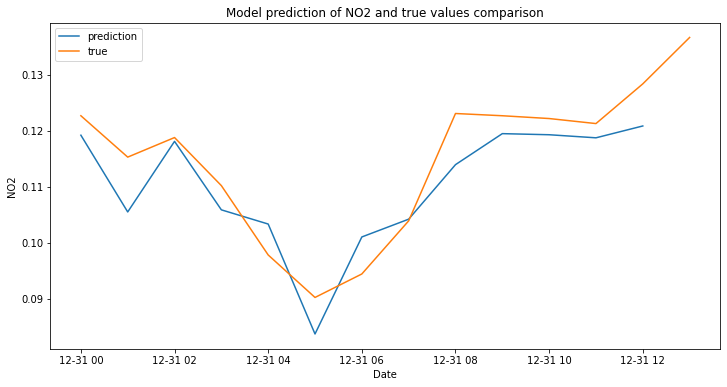

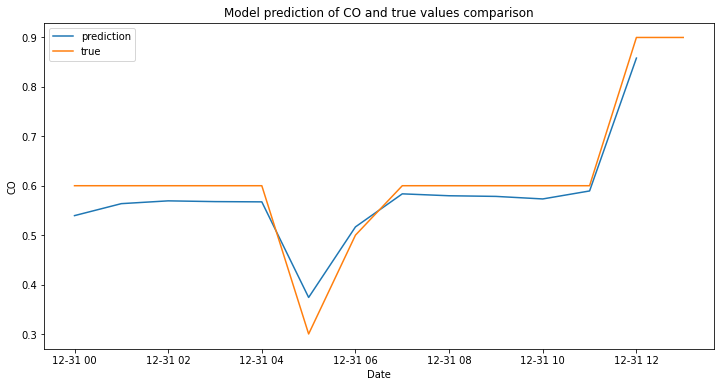

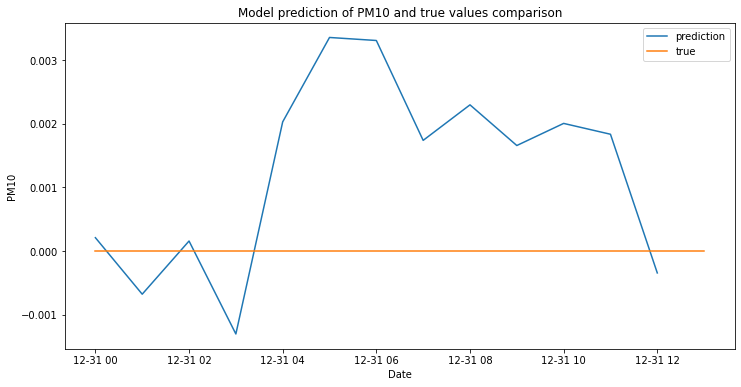

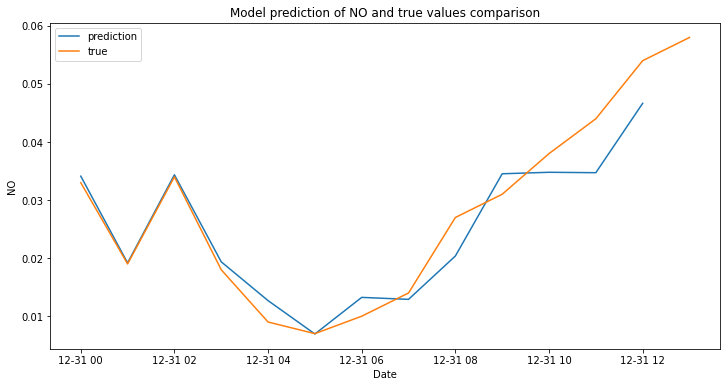

In [ ]:
prediction_shab = training_and_prediction(data_clear)

In [ ]:
#save predictions into file
prediction_shab.to_csv('prediction_shab.csv')

##Maryino Dct.

In [ ]:
mar = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Moscow_contest/mar.csv', decimal=',')
mar = mar.set_index('data_time')
mar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26353 entries, 01/01/2020 00:00:00 to 01/01/2021 00:00:00
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          26353 non-null  int64  
 1   CO                  25959 non-null  object 
 2   NO2                 25966 non-null  object 
 3   NO                  25966 non-null  object 
 4   PM10                25433 non-null  object 
 5   -T-                 25254 non-null  object 
 6   | V |               25254 non-null  object 
 7   _V_                 25254 non-null  object 
 8   Давление            25254 non-null  object 
 9   Влажность           25254 non-null  object 
 10  Осадки              25264 non-null  object 
 11  0                   25673 non-null  float64
 12  50                  25673 non-null  float64
 13  100                 25673 non-null  float64
 14  150                 25673 non-null  float64
 15  200                 25673 

In [ ]:
data_clear = to_numeric(mar)
data_clear = preprocessing(data_clear)
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8785 entries, 2020-01-01 00:00:00 to 2021-01-01 00:00:00
Freq: H
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CO                  8785 non-null   float64
 1   NO2                 8785 non-null   float64
 2   NO                  8785 non-null   float64
 3   PM10                8785 non-null   float64
 4   -T-                 8785 non-null   float64
 5   | V |               8785 non-null   float64
 6   _V_                 8785 non-null   float64
 7   pressure            8785 non-null   float64
 8   humidity            8785 non-null   float64
 9   precipitation       8785 non-null   float64
 10  0                   8785 non-null   float64
 11  50                  8785 non-null   float64
 12  100                 8785 non-null   float64
 13  150                 8785 non-null   float64
 14  200                 8785 non-null   float64
 15  250        

In [ ]:
data_clear.describe()

CO          NO2  ...  OutsideTemperature      Quality
count  8785.000000  8785.000000  ...         8785.000000  8785.000000
mean      0.507661     0.086238  ...           23.103520     0.084234
std       0.588961     0.060969  ...           26.203119     0.430199
min       0.000000     0.000000  ...          -41.480000     0.000000
25%       0.000000     0.039800  ...            1.790000     0.000000
50%       0.300000     0.075600  ...           19.470000     0.000000
75%       0.800000     0.119900  ...           43.930000     0.000000
max       7.000000     0.461200  ...           92.540000     3.000000

[8 rows x 25 columns]

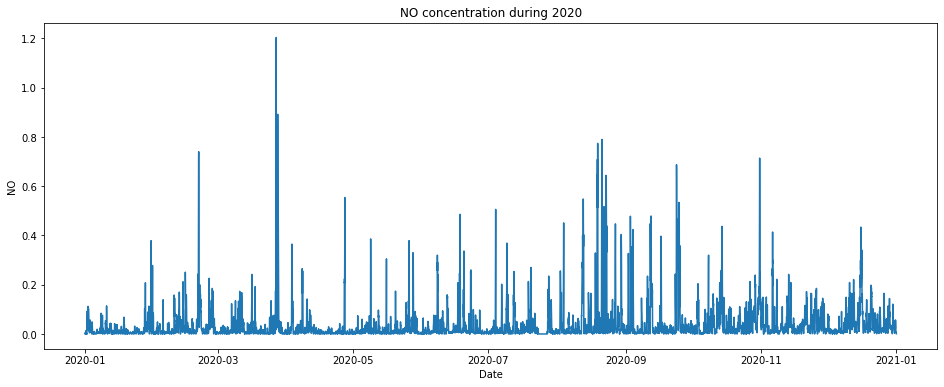

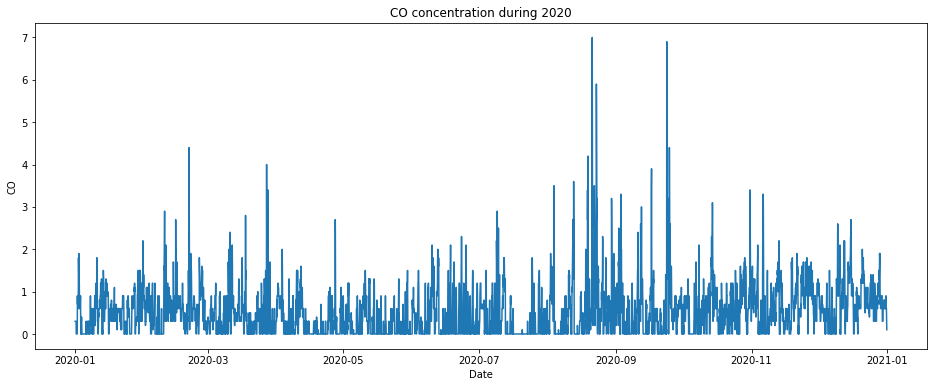

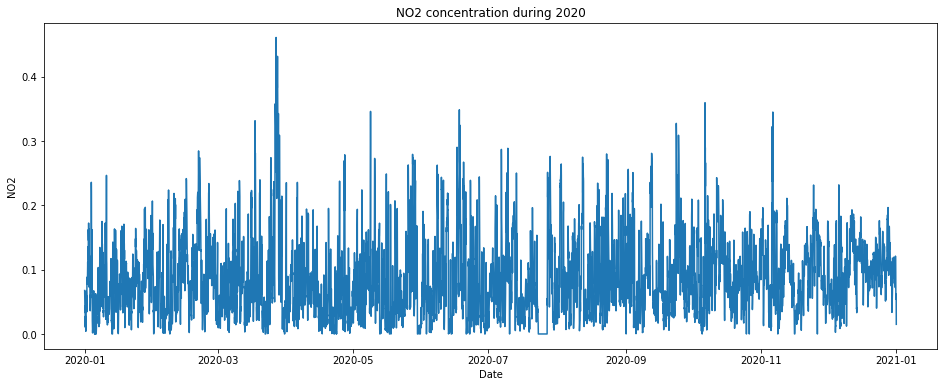

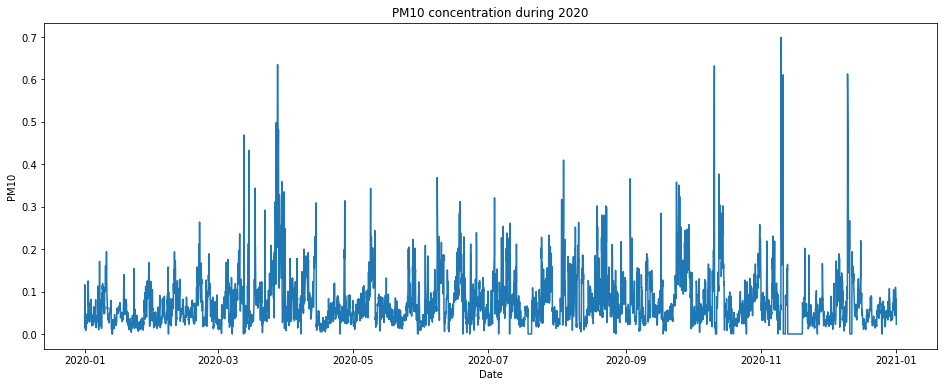

In [ ]:
plot_targets(data_clear)

TRAIN: [   0    1    2 ... 2102 2103 2104] TEST: [2105 2106 2107 ... 4204 4205 4206]
0:	learn: 0.0401962	total: 90ms	remaining: 4.41s
1:	learn: 0.0339842	total: 162ms	remaining: 3.9s
2:	learn: 0.0306107	total: 243ms	remaining: 3.81s
3:	learn: 0.0274133	total: 321ms	remaining: 3.69s
4:	learn: 0.0251549	total: 392ms	remaining: 3.53s
5:	learn: 0.0243011	total: 463ms	remaining: 3.39s
6:	learn: 0.0223466	total: 536ms	remaining: 3.29s
7:	learn: 0.0209512	total: 608ms	remaining: 3.19s
8:	learn: 0.0200816	total: 681ms	remaining: 3.1s
9:	learn: 0.0197255	total: 775ms	remaining: 3.1s
10:	learn: 0.0187158	total: 846ms	remaining: 3s
11:	learn: 0.0180083	total: 919ms	remaining: 2.91s
12:	learn: 0.0177145	total: 993ms	remaining: 2.83s
13:	learn: 0.0175539	total: 1.06s	remaining: 2.74s
14:	learn: 0.0172479	total: 1.13s	remaining: 2.65s
15:	learn: 0.0171334	total: 1.21s	remaining: 2.58s
16:	learn: 0.0170369	total: 1.3s	remaining: 2.52s
17:	learn: 0.0168769	total: 1.37s	remaining: 2.43s
18:	learn: 0.01

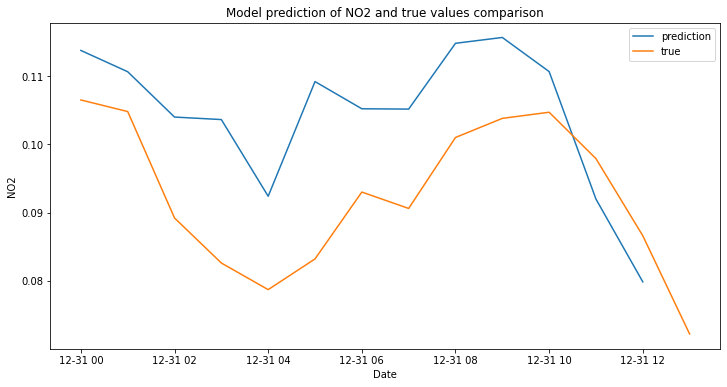

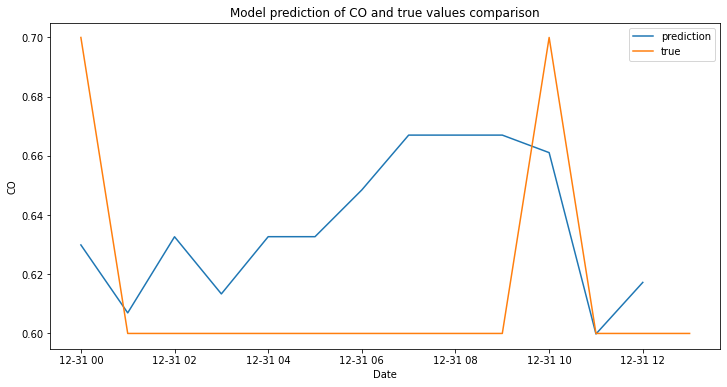

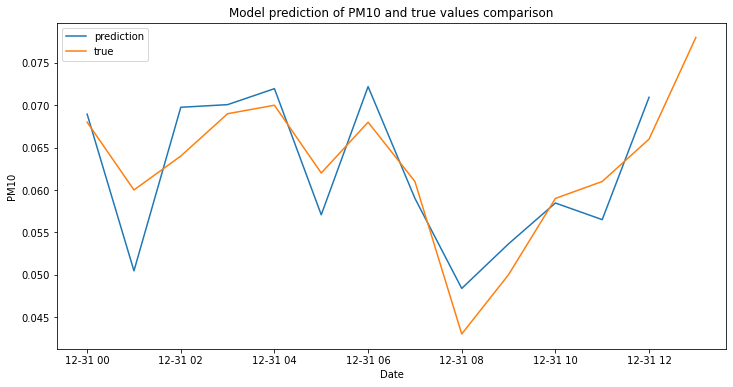

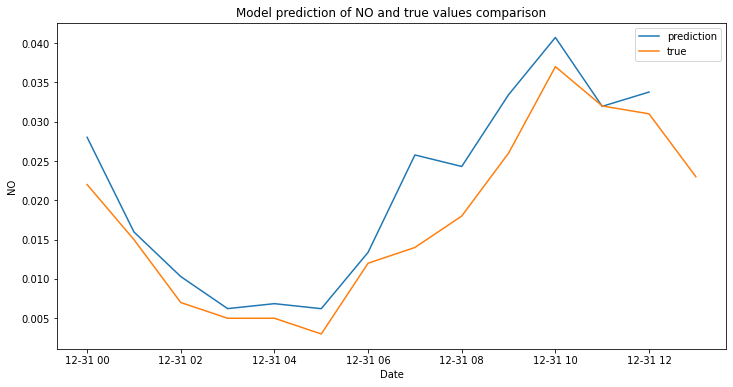

In [ ]:
prediction_mar = training_and_prediction(data_clear)

In [ ]:
#save predictions into file
prediction_mar.to_csv('prediction_mar.csv')

##Proletarskiy Prospect

In [ ]:
prol = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Moscow_contest/prol.csv', decimal=',')
prol = prol.set_index('data_time')
prol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26353 entries, 01/01/2020 00:00:00 to 01/01/2021 00:00:00
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          26353 non-null  int64  
 1   CO                  25459 non-null  object 
 2   NO2                 24443 non-null  object 
 3   NO                  24446 non-null  object 
 4   PM10                24910 non-null  object 
 5   PM2.5               24830 non-null  object 
 6   -T-                 24794 non-null  object 
 7   | V |               24794 non-null  object 
 8   _V_                 24796 non-null  object 
 9   Давление            24794 non-null  object 
 10  Влажность           24794 non-null  object 
 11  Осадки              24810 non-null  object 
 12  0                   25673 non-null  float64
 13  50                  25673 non-null  float64
 14  100                 25673 non-null  float64
 15  150                 25673 

In [ ]:
data_clear = to_numeric(prol)
data_clear = preprocessing(data_clear)
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8785 entries, 2020-01-01 00:00:00 to 2021-01-01 00:00:00
Freq: H
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CO                  8785 non-null   float64
 1   NO2                 8785 non-null   float64
 2   NO                  8785 non-null   float64
 3   PM10                8785 non-null   float64
 4   PM2.5               8785 non-null   float64
 5   -T-                 8785 non-null   float64
 6   | V |               8785 non-null   float64
 7   _V_                 8785 non-null   float64
 8   pressure            8785 non-null   float64
 9   humidity            8785 non-null   float64
 10  precipitation       8785 non-null   float64
 11  0                   8785 non-null   float64
 12  50                  8785 non-null   float64
 13  100                 8785 non-null   float64
 14  150                 8785 non-null   float64
 15  200        

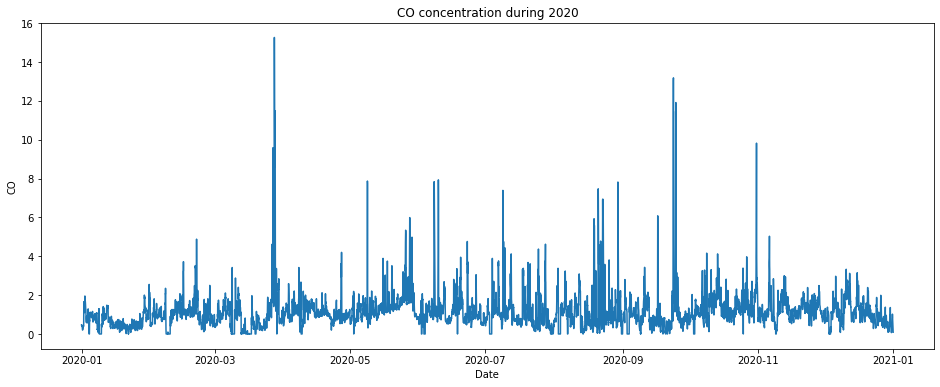

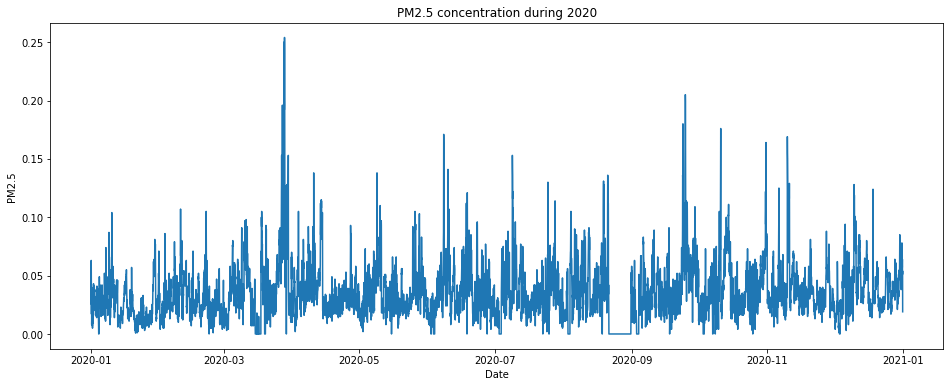

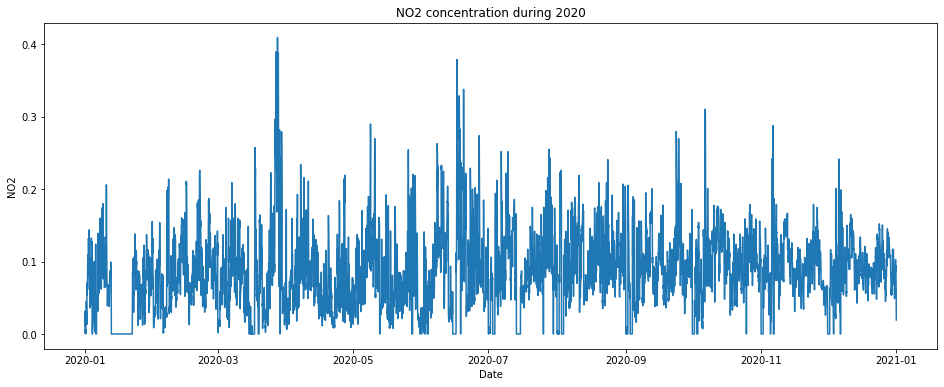

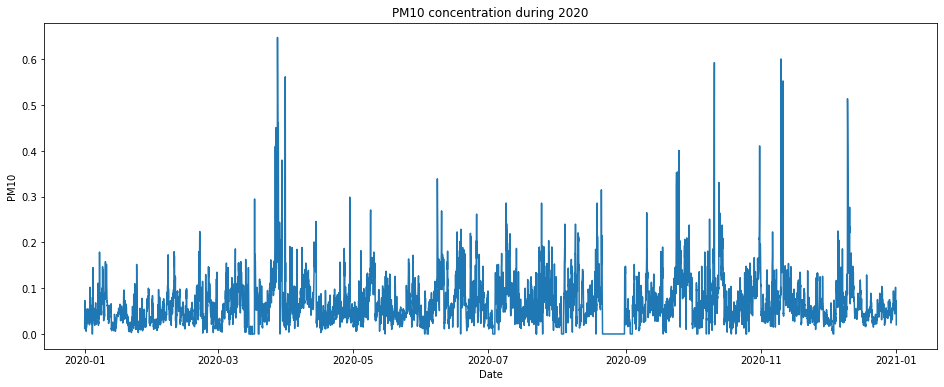

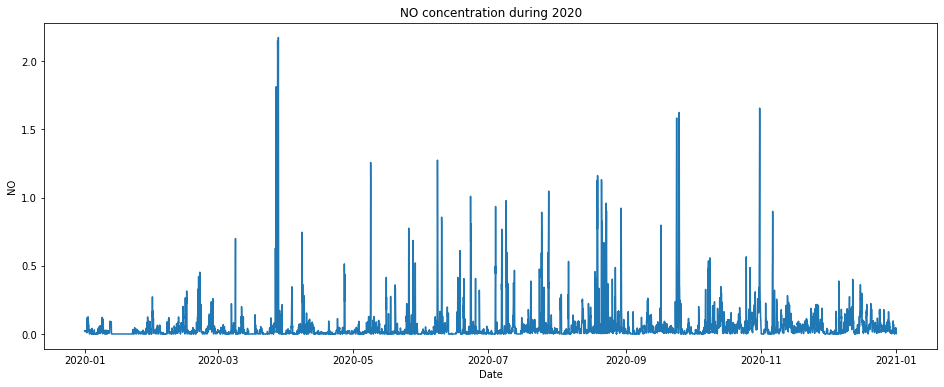

In [ ]:
plot_targets(data_clear)

TRAIN: [   0    1    2 ... 2102 2103 2104] TEST: [2105 2106 2107 ... 4204 4205 4206]
0:	learn: 0.2978157	total: 127ms	remaining: 6.24s
1:	learn: 0.2509733	total: 232ms	remaining: 5.57s
2:	learn: 0.2216969	total: 335ms	remaining: 5.25s
3:	learn: 0.1939387	total: 433ms	remaining: 4.98s
4:	learn: 0.1816838	total: 552ms	remaining: 4.97s
5:	learn: 0.1603243	total: 652ms	remaining: 4.78s
6:	learn: 0.1453841	total: 755ms	remaining: 4.64s
7:	learn: 0.1394651	total: 854ms	remaining: 4.48s
8:	learn: 0.1356813	total: 954ms	remaining: 4.35s
9:	learn: 0.1331807	total: 1.05s	remaining: 4.22s
10:	learn: 0.1267054	total: 1.16s	remaining: 4.1s
11:	learn: 0.1258248	total: 1.25s	remaining: 3.97s
12:	learn: 0.1248870	total: 1.36s	remaining: 3.87s
13:	learn: 0.1239004	total: 1.46s	remaining: 3.75s
14:	learn: 0.1204772	total: 1.57s	remaining: 3.66s
15:	learn: 0.1193507	total: 1.67s	remaining: 3.56s
16:	learn: 0.1188136	total: 1.78s	remaining: 3.46s
17:	learn: 0.1182127	total: 1.92s	remaining: 3.4s
18:	learn

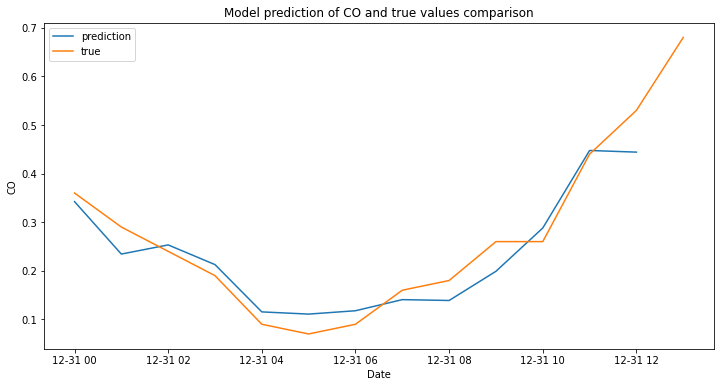

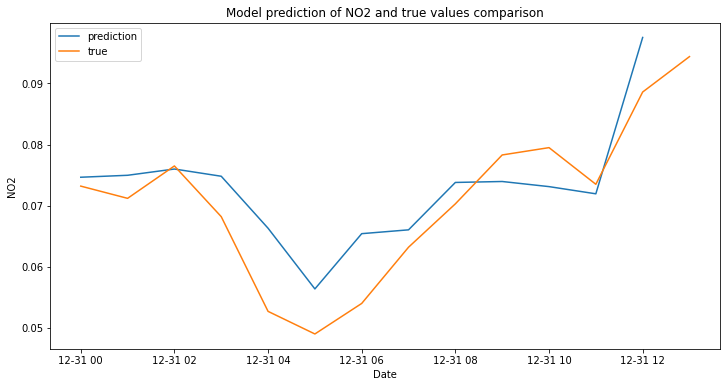

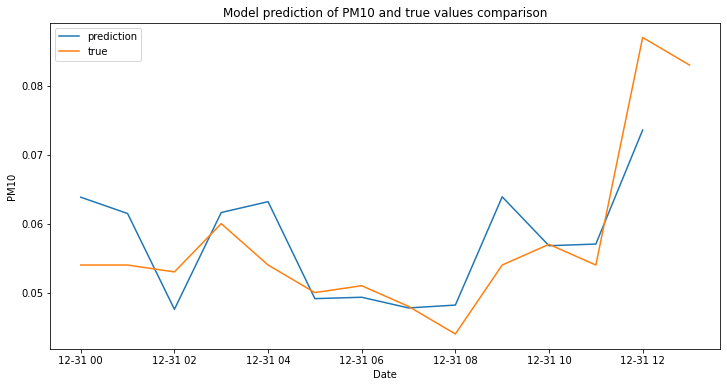

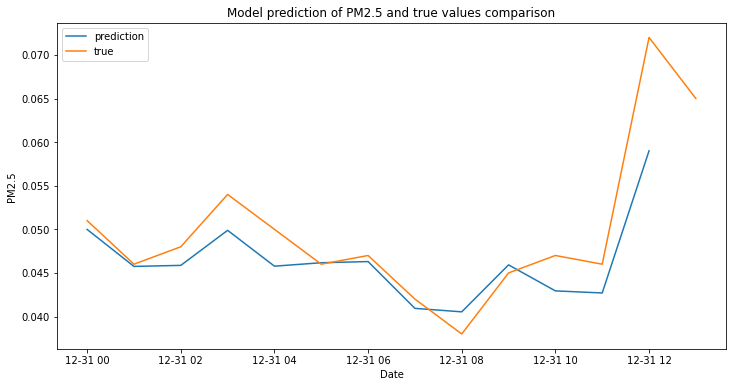

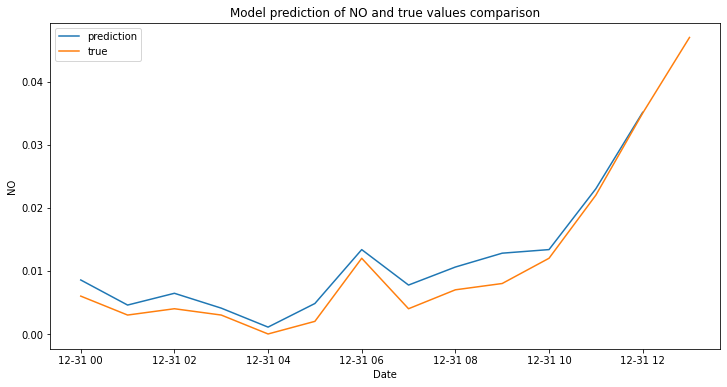

In [ ]:
prediction_prol = training_and_prediction(data_clear)

In [ ]:
#save predictions into file
prediction_prol.to_csv('prediction_prol.csv')

##Ostankino

In [ ]:
ost = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Moscow_contest/ost.csv', decimal=',')
ost = ost.set_index('data_time')
ost.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26352 entries, 01/01/2020 00:00:00 to 31/12/2020 23:40:00
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          26352 non-null  int64  
 1   CO                  25570 non-null  object 
 2   NO2                 22876 non-null  object 
 3   NO                  22874 non-null  object 
 4   PM10                19902 non-null  object 
 5   PM2.5               11854 non-null  object 
 6   Unnamed: 6          0 non-null      float64
 7   -T-                 25502 non-null  object 
 8   | V |               25502 non-null  object 
 9   _V_                 25501 non-null  object 
 10  Давление            25502 non-null  object 
 11  Влажность           25502 non-null  object 
 12  Осадки              25502 non-null  object 
 13  0                   25673 non-null  float64
 14  50                  25673 non-null  float64
 15  100                 25673 

In [ ]:
data_clear = to_numeric(ost)
data_clear = preprocessing(data_clear)
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Freq: H
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CO                  8784 non-null   float64
 1   NO2                 8784 non-null   float64
 2   NO                  8784 non-null   float64
 3   PM10                8784 non-null   float64
 4   PM2.5               8784 non-null   float64
 5   -T-                 8784 non-null   float64
 6   | V |               8784 non-null   float64
 7   _V_                 8784 non-null   float64
 8   pressure            8784 non-null   float64
 9   humidity            8784 non-null   float64
 10  precipitation       8784 non-null   float64
 11  0                   8784 non-null   float64
 12  50                  8784 non-null   float64
 13  100                 8784 non-null   float64
 14  150                 8784 non-null   float64
 15  200        

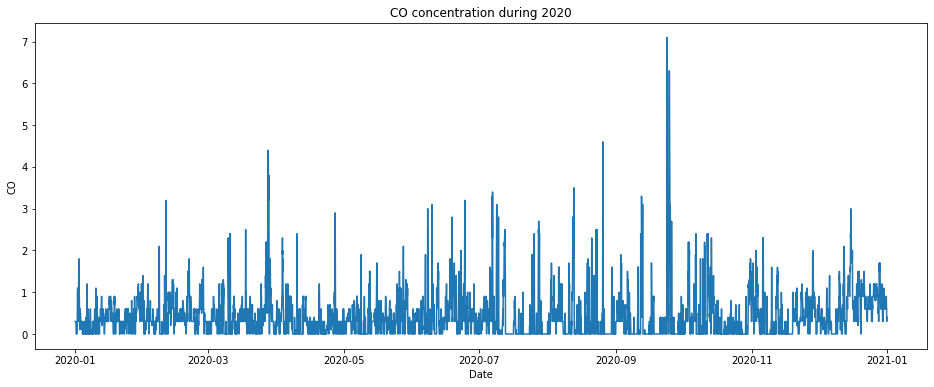

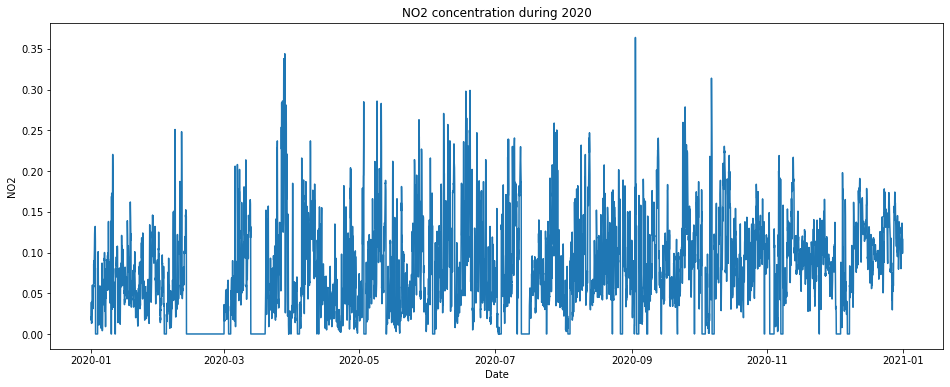

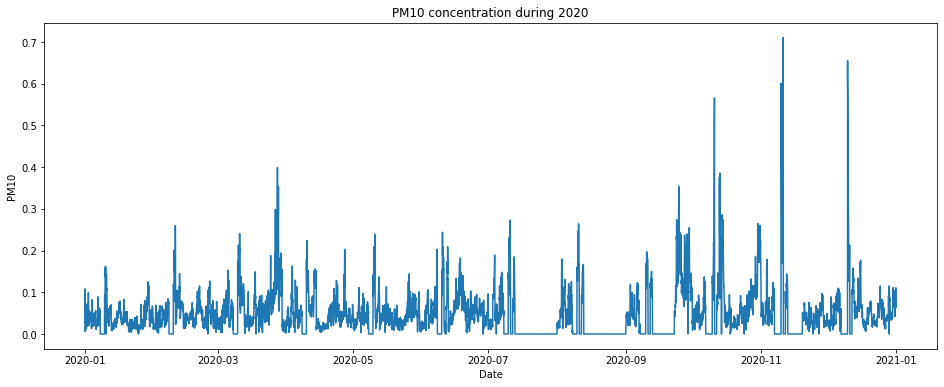

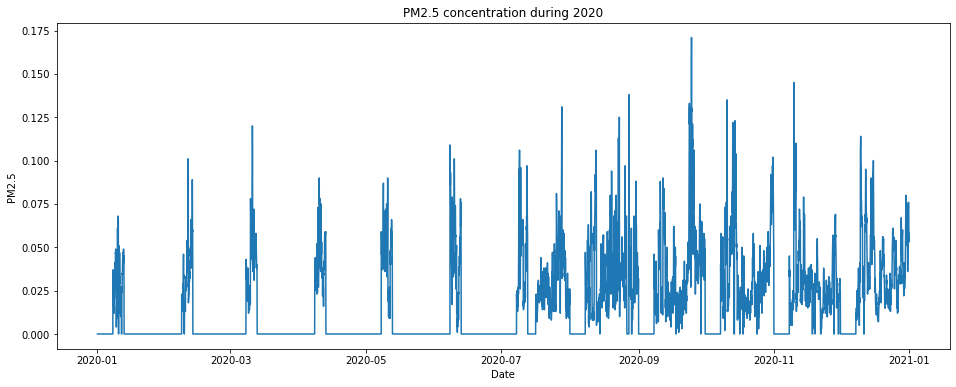

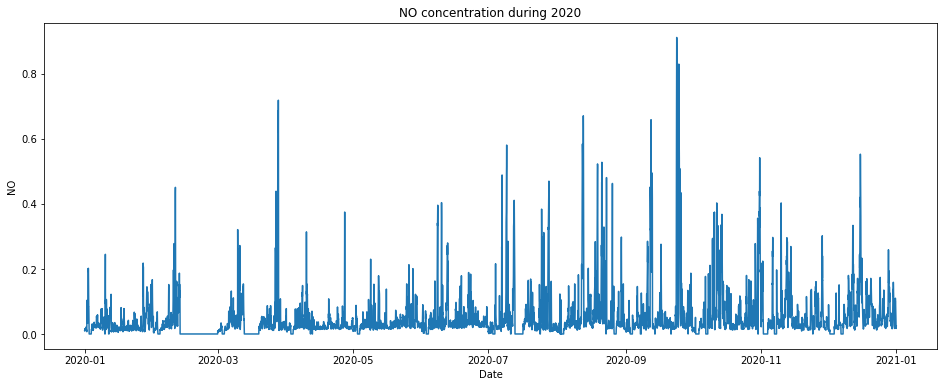

In [ ]:
plot_targets(data_clear)

TRAIN: [   0    1    2 ... 2102 2103 2104] TEST: [2105 2106 2107 ... 4204 4205 4206]
0:	learn: 0.2090076	total: 90.2ms	remaining: 4.42s
1:	learn: 0.1899257	total: 165ms	remaining: 3.95s
2:	learn: 0.1779169	total: 239ms	remaining: 3.75s
3:	learn: 0.1691356	total: 326ms	remaining: 3.75s
4:	learn: 0.1643246	total: 399ms	remaining: 3.6s
5:	learn: 0.1507943	total: 474ms	remaining: 3.47s
6:	learn: 0.1412008	total: 549ms	remaining: 3.37s
7:	learn: 0.1321999	total: 623ms	remaining: 3.27s
8:	learn: 0.1259398	total: 699ms	remaining: 3.19s
9:	learn: 0.1225027	total: 786ms	remaining: 3.15s
10:	learn: 0.1194246	total: 861ms	remaining: 3.05s
11:	learn: 0.1163676	total: 934ms	remaining: 2.96s
12:	learn: 0.1149266	total: 1.02s	remaining: 2.89s
13:	learn: 0.1142335	total: 1.09s	remaining: 2.81s
14:	learn: 0.1140993	total: 1.17s	remaining: 2.73s
15:	learn: 0.1136964	total: 1.25s	remaining: 2.65s
16:	learn: 0.1132873	total: 1.33s	remaining: 2.58s
17:	learn: 0.1130834	total: 1.4s	remaining: 2.49s
18:	lear

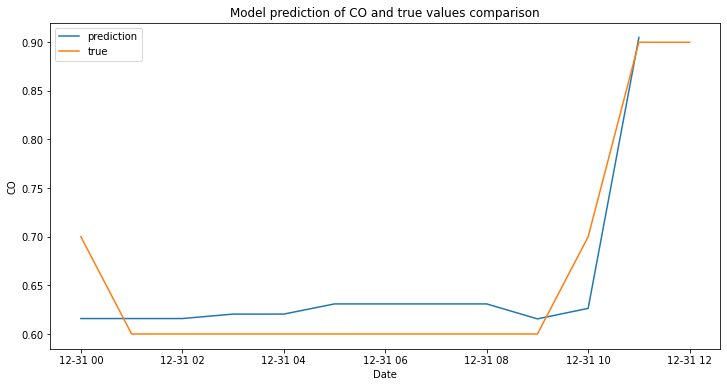

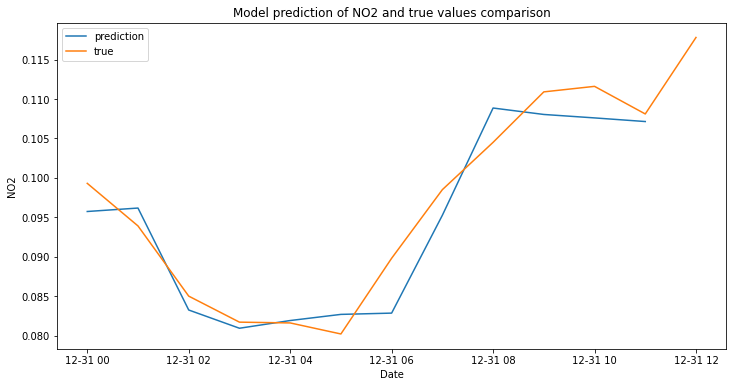

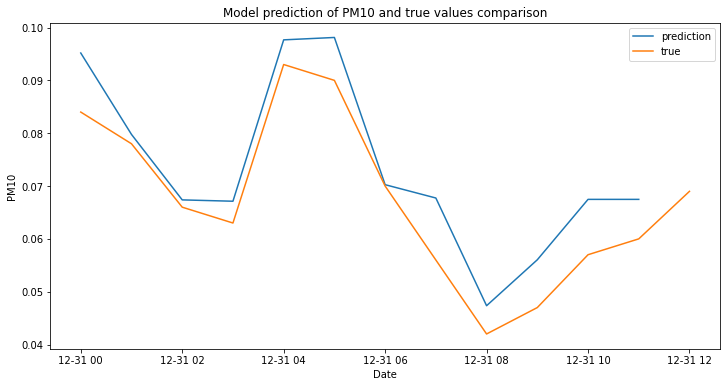

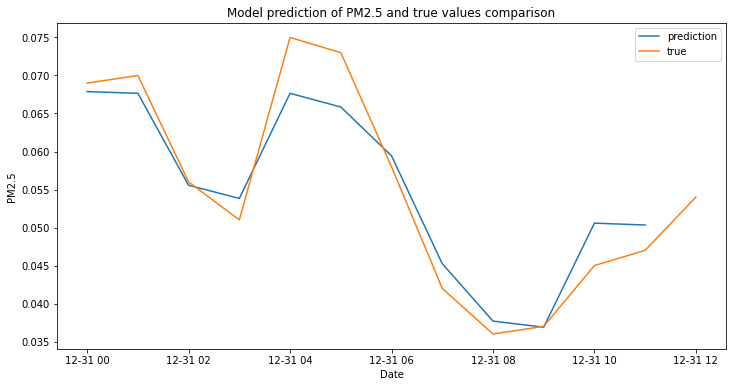

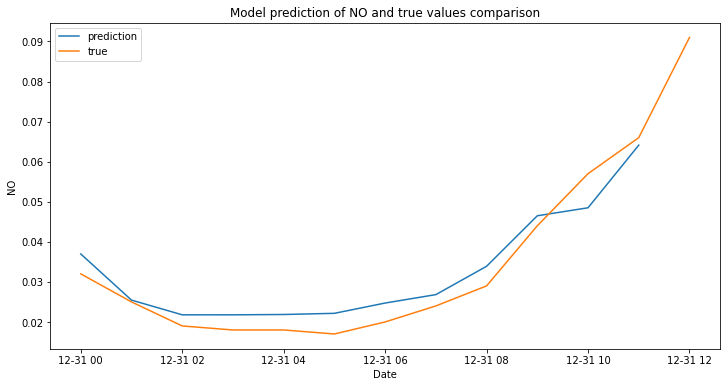

In [ ]:
prediction_ost = training_and_prediction(data_clear)

In [ ]:
#save predictions into file
prediction_ost.to_csv('prediction_ost.csv')

##Glebovskaya St.

In [ ]:
gleb = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Moscow_contest/gleb.csv', decimal=',')
gleb = gleb.set_index('data_time')
gleb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26352 entries, 01/01/2020 00:00:00 to 31/12/2020 23:40:00
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          26352 non-null  int64  
 1   CO                  24672 non-null  object 
 2   NO2                 22213 non-null  object 
 3   NO                  23615 non-null  object 
 4   PM10                22593 non-null  object 
 5   PM25                22587 non-null  object 
 6   Unnamed: 6          0 non-null      float64
 7   -T-                 7493 non-null   object 
 8   | V |               7493 non-null   object 
 9   _V_                 7493 non-null   object 
 10  Давление            7562 non-null   object 
 11  Влажность           7493 non-null   object 
 12  Осадки              7493 non-null   object 
 13  0                   25673 non-null  float64
 14  50                  25673 non-null  float64
 15  100                 25673 

In [ ]:
data_clear = to_numeric(gleb)
data_clear = preprocessing(data_clear)
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Freq: H
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CO                  8784 non-null   float64
 1   NO2                 8784 non-null   float64
 2   NO                  8784 non-null   float64
 3   PM10                8784 non-null   float64
 4   PM25                8784 non-null   float64
 5   -T-                 8784 non-null   float64
 6   | V |               8784 non-null   float64
 7   _V_                 8784 non-null   float64
 8   pressure            8784 non-null   float64
 9   humidity            8784 non-null   float64
 10  precipitation       8784 non-null   float64
 11  0                   8784 non-null   float64
 12  50                  8784 non-null   float64
 13  100                 8784 non-null   float64
 14  150                 8784 non-null   float64
 15  200        

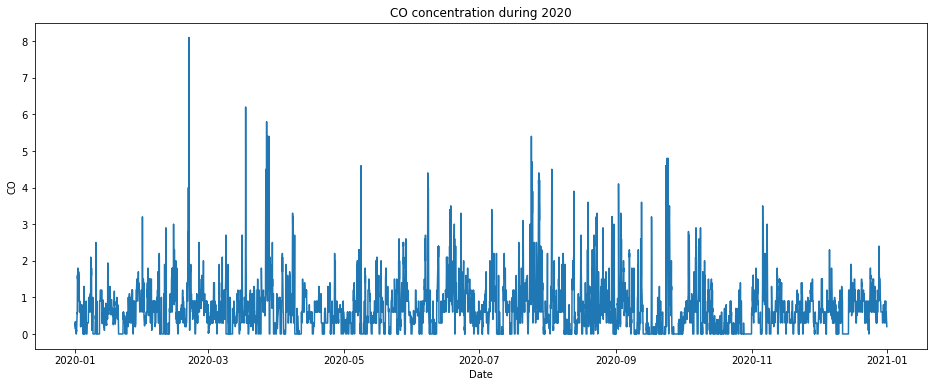

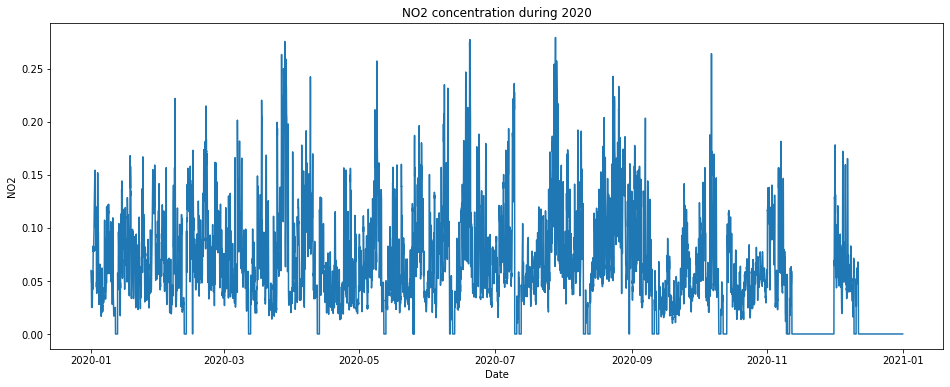

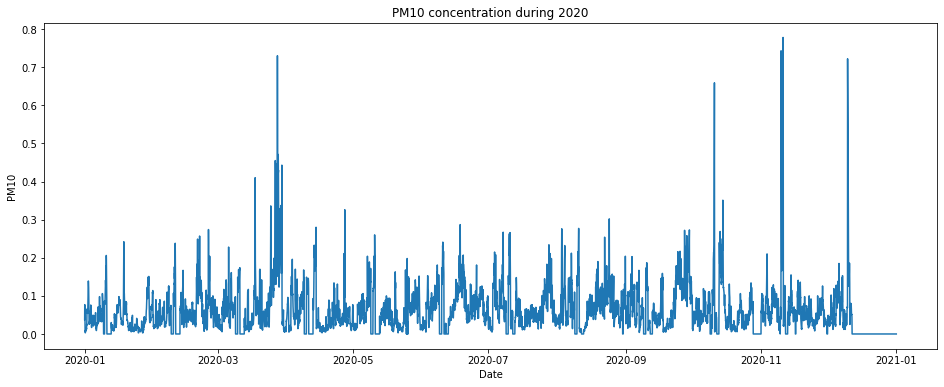

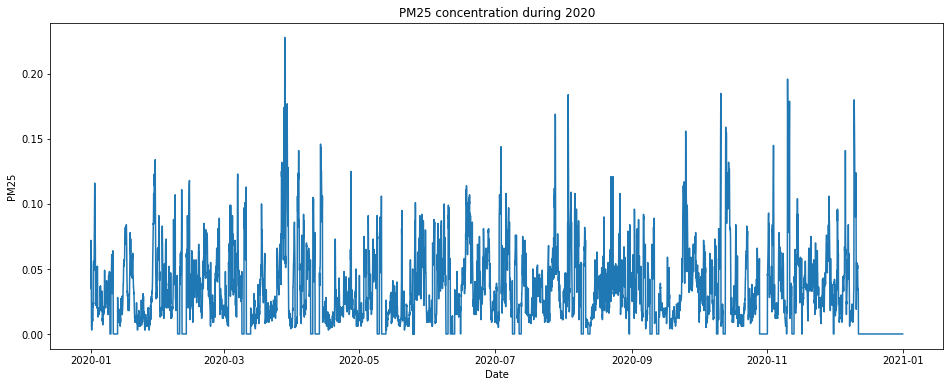

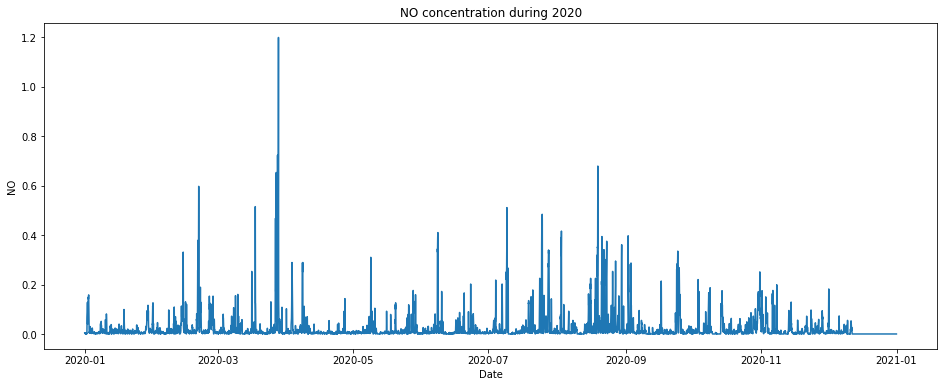

In [ ]:
plot_targets(data_clear)

TRAIN: [   0    1    2 ... 2102 2103 2104] TEST: [2105 2106 2107 ... 4204 4205 4206]
0:	learn: 0.2957408	total: 107ms	remaining: 5.25s
1:	learn: 0.2445160	total: 199ms	remaining: 4.77s
2:	learn: 0.2140454	total: 290ms	remaining: 4.54s
3:	learn: 0.1913421	total: 387ms	remaining: 4.46s
4:	learn: 0.1798166	total: 485ms	remaining: 4.37s
5:	learn: 0.1685418	total: 589ms	remaining: 4.32s
6:	learn: 0.1565576	total: 686ms	remaining: 4.21s
7:	learn: 0.1535133	total: 781ms	remaining: 4.1s
8:	learn: 0.1512751	total: 875ms	remaining: 3.98s
9:	learn: 0.1488121	total: 966ms	remaining: 3.86s
10:	learn: 0.1437742	total: 1.06s	remaining: 3.75s
11:	learn: 0.1430290	total: 1.16s	remaining: 3.66s
12:	learn: 0.1427082	total: 1.25s	remaining: 3.54s
13:	learn: 0.1393110	total: 1.34s	remaining: 3.44s
14:	learn: 0.1379824	total: 1.44s	remaining: 3.37s
15:	learn: 0.1376607	total: 1.54s	remaining: 3.28s
16:	learn: 0.1373545	total: 1.65s	remaining: 3.19s
17:	learn: 0.1371195	total: 1.74s	remaining: 3.09s
18:	lear

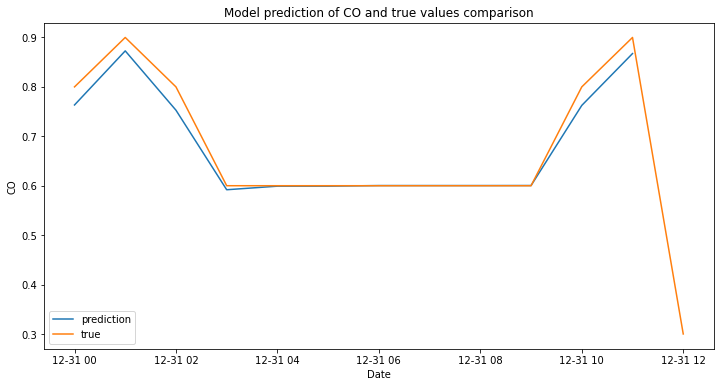

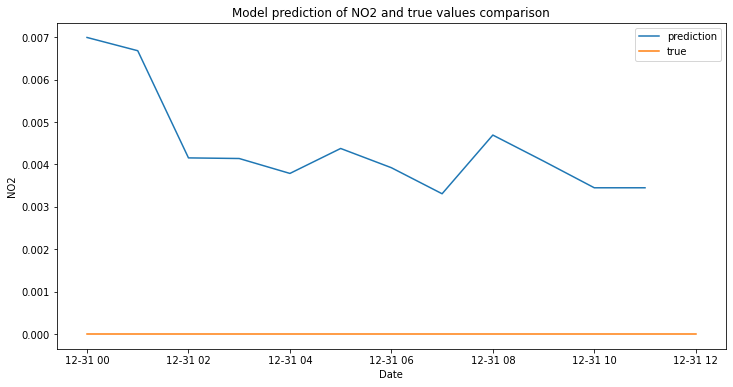

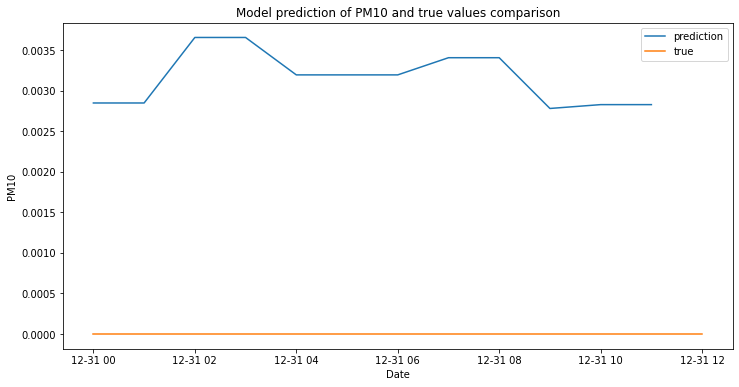

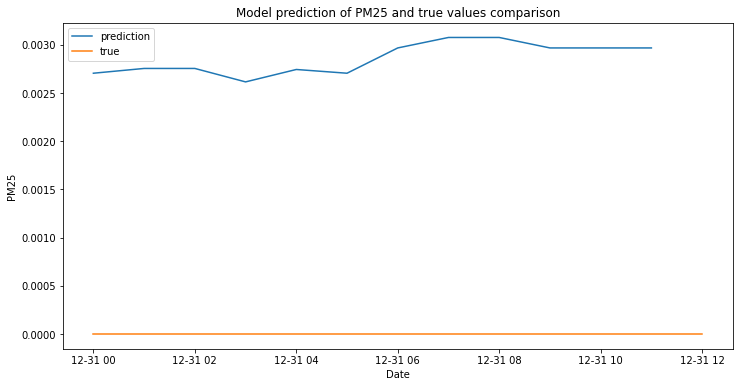

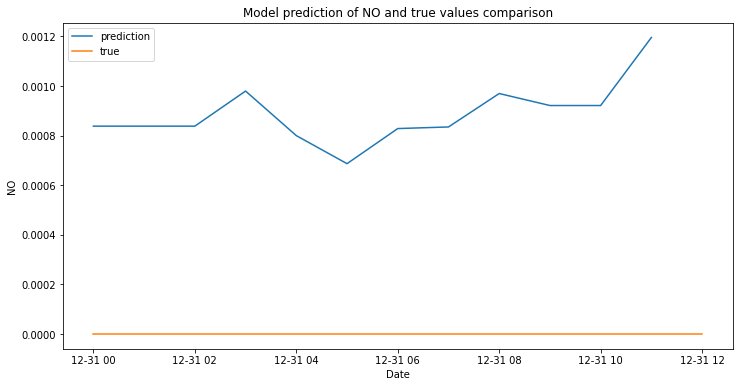

In [ ]:
prediction_gleb = training_and_prediction(data_clear)

In [ ]:
#save predictions into file
prediction_gleb.to_csv('prediction_gleb.csv')

##Spiridonovka St.

In [ ]:
spir = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Moscow_contest/spir.csv', decimal=',')
spir = spir.set_index('data_time')
spir.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26352 entries, 01/01/2020 00:00:00 to 31/12/2020 23:40:00
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          26352 non-null  int64  
 1   CO                  26056 non-null  object 
 2   NO2                 25949 non-null  object 
 3   NO                  25949 non-null  object 
 4   PM10                23245 non-null  object 
 5   PM2.5               23022 non-null  object 
 6   Unnamed: 6          0 non-null      float64
 7   -T-                 24176 non-null  object 
 8   | V |               24176 non-null  object 
 9   _V_                 24176 non-null  object 
 10  Давление            24176 non-null  object 
 11  Влажность           24176 non-null  object 
 12  Осадки              24176 non-null  object 
 13  0                   25673 non-null  float64
 14  50                  25673 non-null  float64
 15  100                 25673 

In [ ]:
data_clear = to_numeric(spir)
data_clear = preprocessing(data_clear)
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Freq: H
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CO                  8784 non-null   float64
 1   NO2                 8784 non-null   float64
 2   NO                  8784 non-null   float64
 3   PM10                8784 non-null   float64
 4   PM2.5               8784 non-null   float64
 5   -T-                 8784 non-null   float64
 6   | V |               8784 non-null   float64
 7   _V_                 8784 non-null   float64
 8   pressure            8784 non-null   float64
 9   humidity            8784 non-null   float64
 10  precipitation       8784 non-null   float64
 11  0                   8784 non-null   float64
 12  50                  8784 non-null   float64
 13  100                 8784 non-null   float64
 14  150                 8784 non-null   float64
 15  200        

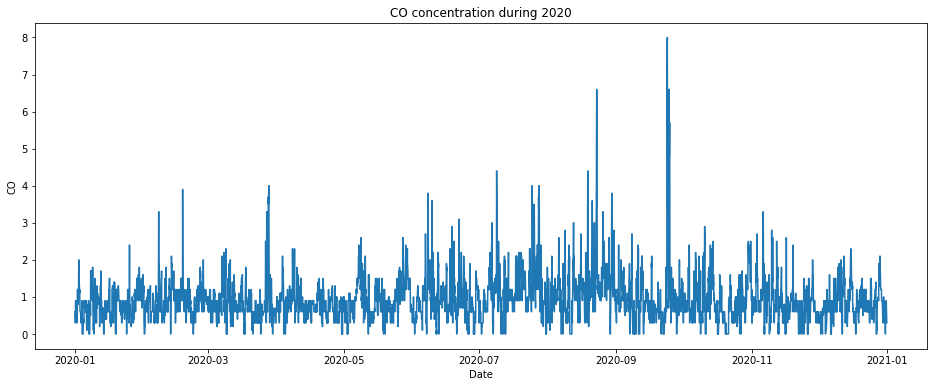

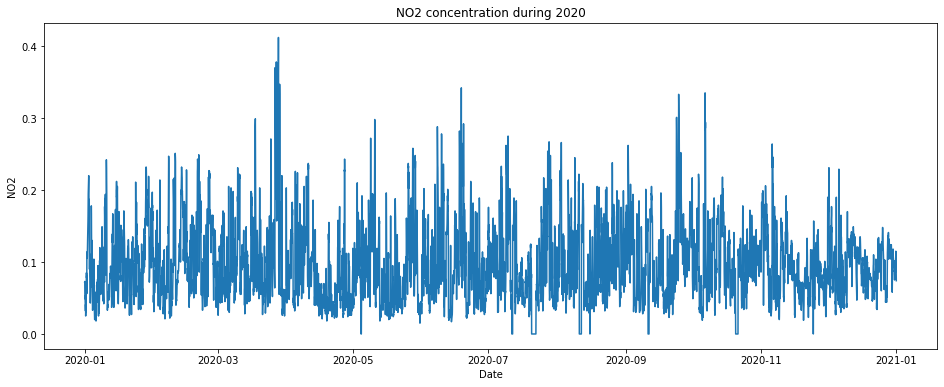

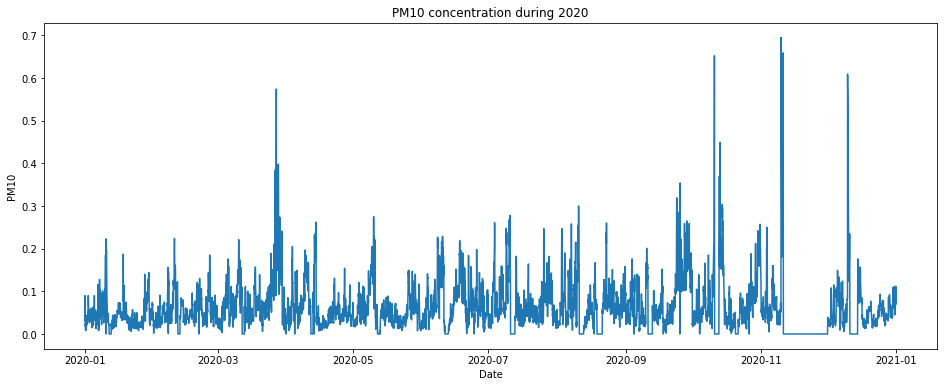

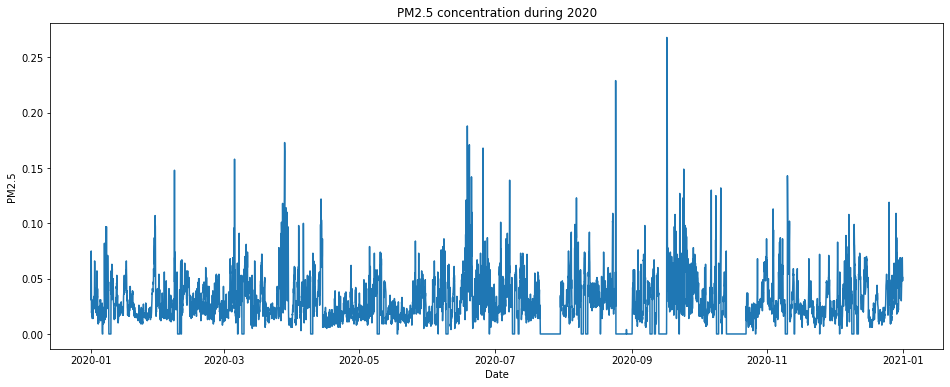

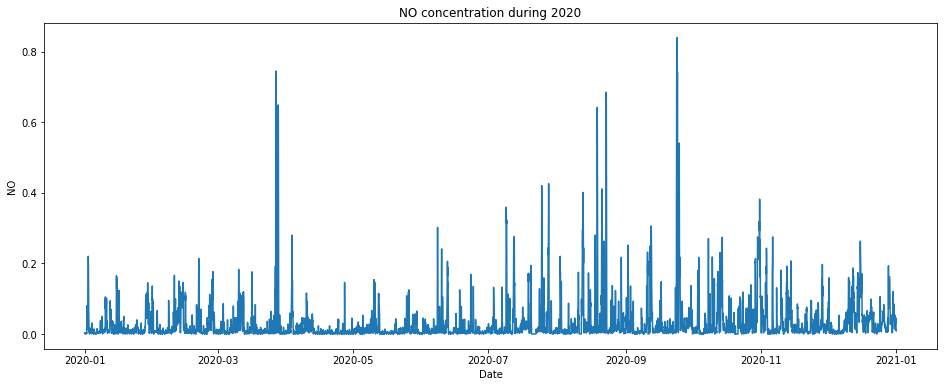

In [ ]:
plot_targets(data_clear)

TRAIN: [   0    1    2 ... 2102 2103 2104] TEST: [2105 2106 2107 ... 4204 4205 4206]
0:	learn: 0.2314142	total: 109ms	remaining: 5.33s
1:	learn: 0.2120757	total: 186ms	remaining: 4.46s
2:	learn: 0.1898950	total: 263ms	remaining: 4.12s
3:	learn: 0.1741367	total: 342ms	remaining: 3.93s
4:	learn: 0.1685464	total: 424ms	remaining: 3.81s
5:	learn: 0.1638563	total: 505ms	remaining: 3.7s
6:	learn: 0.1493596	total: 589ms	remaining: 3.62s
7:	learn: 0.1454092	total: 668ms	remaining: 3.51s
8:	learn: 0.1430645	total: 751ms	remaining: 3.42s
9:	learn: 0.1361970	total: 830ms	remaining: 3.32s
10:	learn: 0.1353657	total: 909ms	remaining: 3.22s
11:	learn: 0.1313233	total: 989ms	remaining: 3.13s
12:	learn: 0.1274220	total: 1.07s	remaining: 3.04s
13:	learn: 0.1248257	total: 1.16s	remaining: 2.97s
14:	learn: 0.1231972	total: 1.23s	remaining: 2.88s
15:	learn: 0.1188669	total: 1.31s	remaining: 2.79s
16:	learn: 0.1174579	total: 1.39s	remaining: 2.71s
17:	learn: 0.1172782	total: 1.48s	remaining: 2.62s
18:	lear

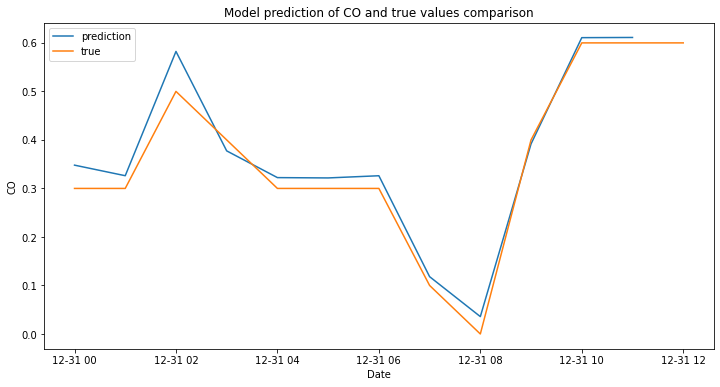

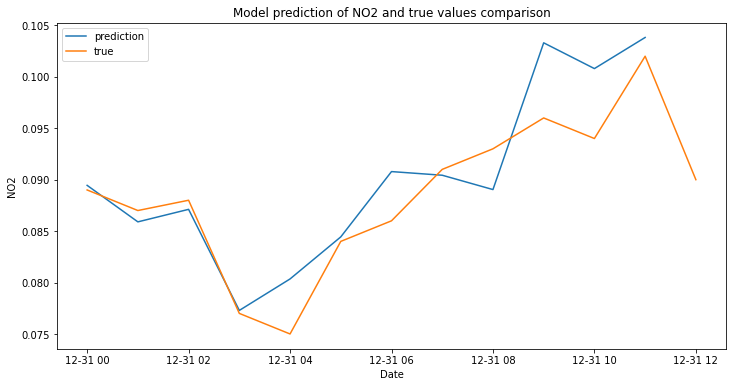

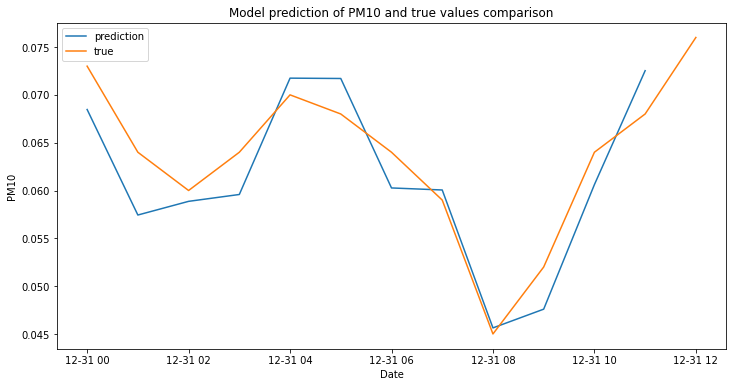

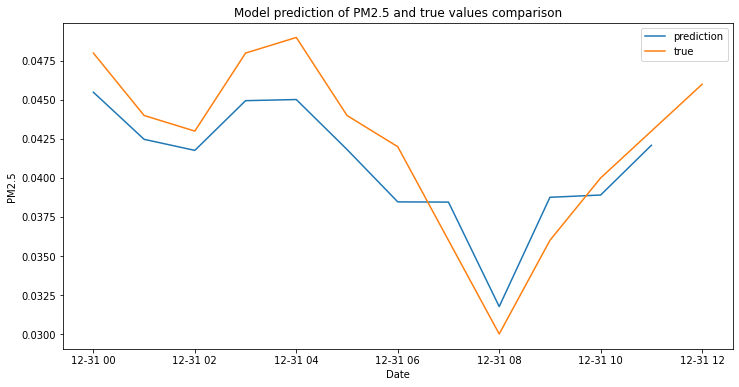

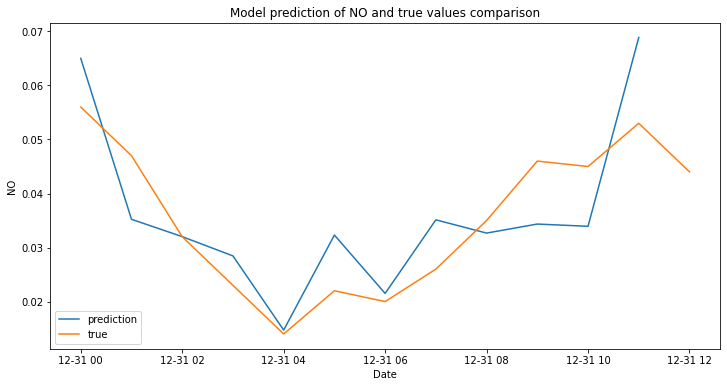

In [ ]:
prediction_spir = training_and_prediction(data_clear)

In [ ]:
#save predictions into file
prediction_spir.to_csv('prediction_spir.csv')

##Turistskaya St.

In [ ]:
tur = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Moscow_contest/tur.csv', decimal=',')
tur = tur.set_index('data_time')
tur.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26352 entries, 01/01/2020 00:00:00 to 31/12/2020 23:40:00
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          26352 non-null  int64  
 1   CO                  23463 non-null  object 
 2   NO2                 24652 non-null  object 
 3   NO                  24674 non-null  object 
 4   PM10                11523 non-null  object 
 5   PM2.5               12321 non-null  object 
 6   Unnamed: 6          0 non-null      float64
 7   -T-                 24579 non-null  object 
 8   | V |               24579 non-null  object 
 9   _V_                 24579 non-null  object 
 10  Давление            24579 non-null  object 
 11  Влажность           24579 non-null  object 
 12  Осадки              13510 non-null  object 
 13  0                   25673 non-null  float64
 14  50                  25673 non-null  float64
 15  100                 25673 

In [ ]:
data_clear = to_numeric(tur)
data_clear = preprocessing(data_clear)
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Freq: H
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CO                  8784 non-null   float64
 1   NO2                 8784 non-null   float64
 2   NO                  8784 non-null   float64
 3   PM10                8784 non-null   float64
 4   PM2.5               8784 non-null   float64
 5   -T-                 8784 non-null   float64
 6   | V |               8784 non-null   float64
 7   _V_                 8784 non-null   float64
 8   pressure            8784 non-null   float64
 9   humidity            8784 non-null   float64
 10  precipitation       8784 non-null   float64
 11  0                   8784 non-null   float64
 12  50                  8784 non-null   float64
 13  100                 8784 non-null   float64
 14  150                 8784 non-null   float64
 15  200        

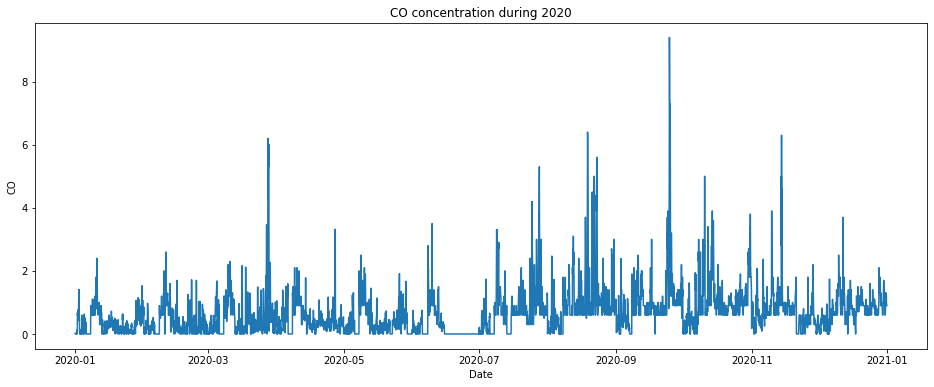

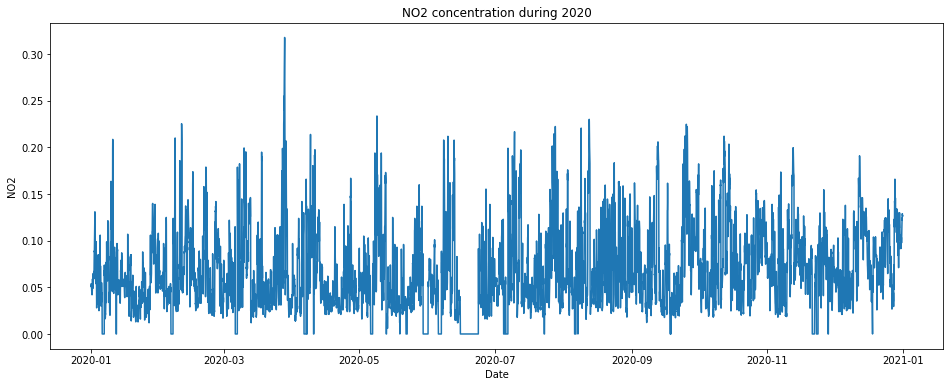

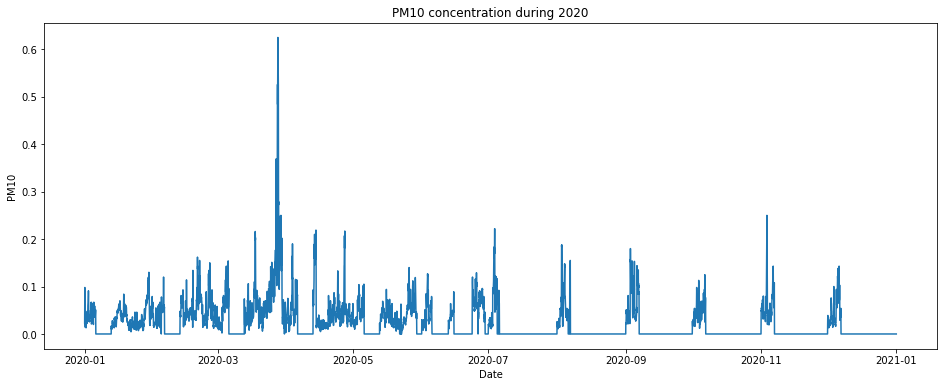

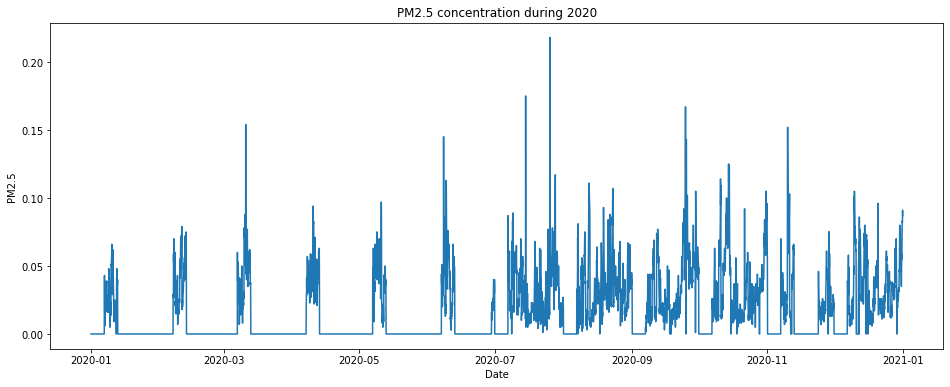

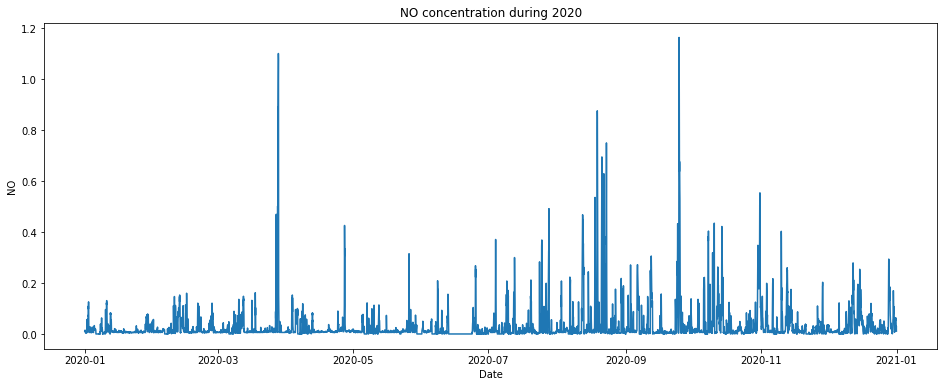

In [ ]:
plot_targets(data_clear)

TRAIN: [   0    1    2 ... 2102 2103 2104] TEST: [2105 2106 2107 ... 4204 4205 4206]
0:	learn: 0.2508957	total: 98.8ms	remaining: 4.84s
1:	learn: 0.2122786	total: 183ms	remaining: 4.39s
2:	learn: 0.1853244	total: 266ms	remaining: 4.17s
3:	learn: 0.1600728	total: 350ms	remaining: 4.03s
4:	learn: 0.1454023	total: 439ms	remaining: 3.95s
5:	learn: 0.1388662	total: 522ms	remaining: 3.83s
6:	learn: 0.1326778	total: 619ms	remaining: 3.8s
7:	learn: 0.1314741	total: 703ms	remaining: 3.69s
8:	learn: 0.1305650	total: 785ms	remaining: 3.58s
9:	learn: 0.1298111	total: 870ms	remaining: 3.48s
10:	learn: 0.1285033	total: 953ms	remaining: 3.38s
11:	learn: 0.1241487	total: 1.03s	remaining: 3.28s
12:	learn: 0.1214696	total: 1.12s	remaining: 3.19s
13:	learn: 0.1210668	total: 1.21s	remaining: 3.1s
14:	learn: 0.1188521	total: 1.29s	remaining: 3s
15:	learn: 0.1180979	total: 1.37s	remaining: 2.92s
16:	learn: 0.1173834	total: 1.46s	remaining: 2.82s
17:	learn: 0.1170607	total: 1.54s	remaining: 2.74s
18:	learn: 

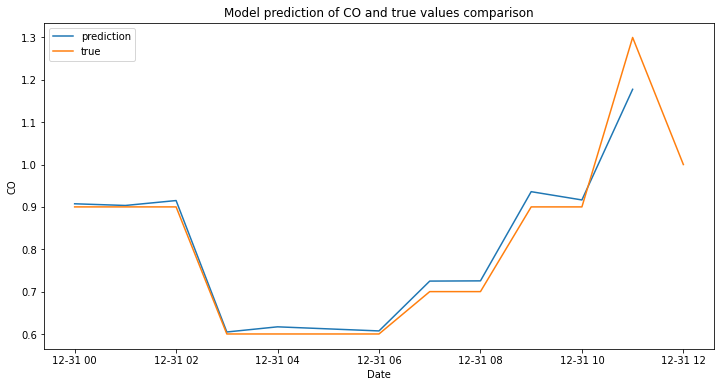

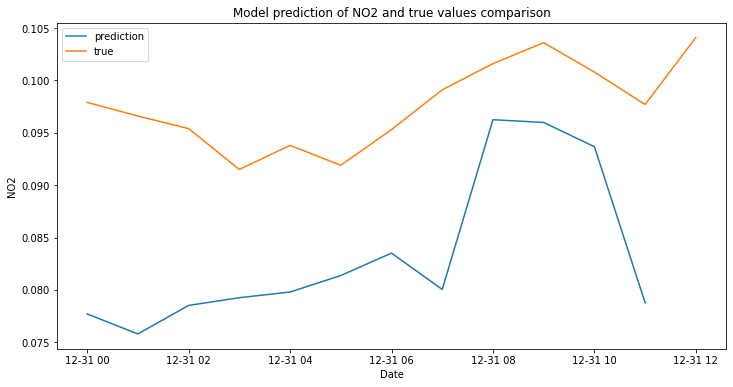

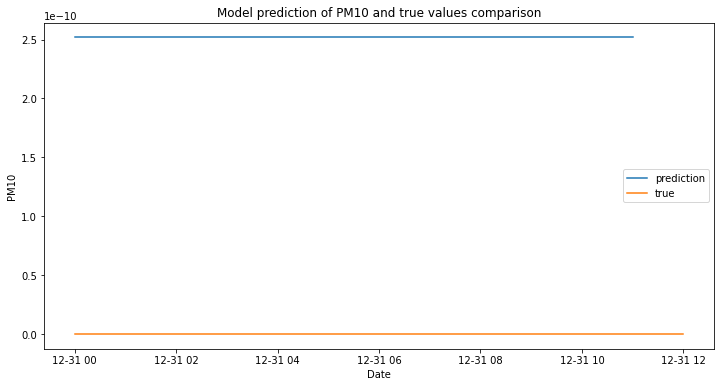

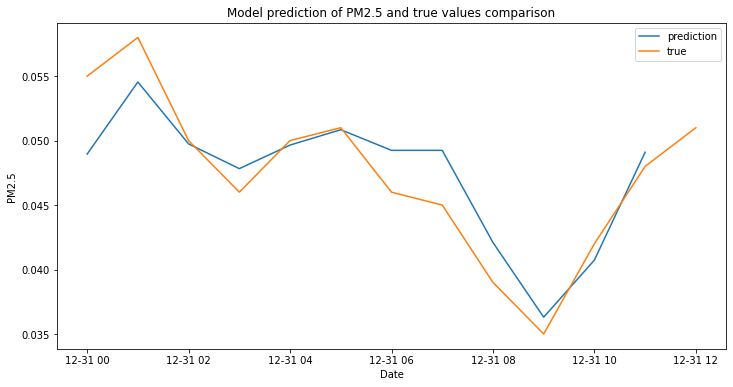

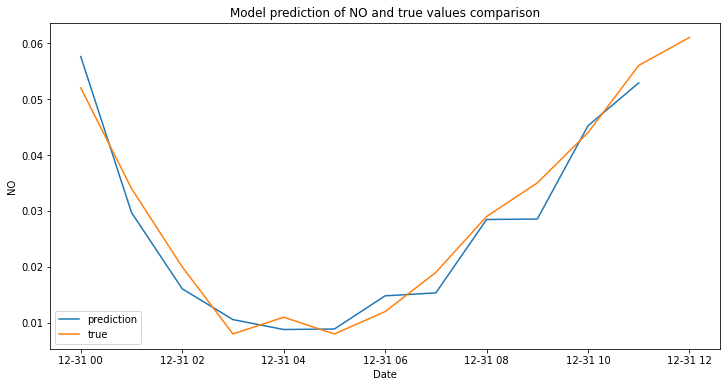

In [ ]:
prediction_tur = training_and_prediction(data_clear)

In [ ]:
#save predictions into file
prediction_tur.to_csv('prediction_tur.csv')

##Academic Anokhin St.

In [ ]:
anoh = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Moscow_contest/anoh.csv', decimal=',')
anoh = anoh.set_index('data_time')
anoh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26353 entries, 01/01/2020 00:00:00 to 01/01/2021 00:00:00
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          26353 non-null  int64  
 1   CO                  24096 non-null  object 
 2   NO2                 25427 non-null  object 
 3   NO                  25429 non-null  object 
 4   PM2.5               12776 non-null  object 
 5   -T-                 25184 non-null  object 
 6   | V |               25397 non-null  object 
 7   _V_                 25397 non-null  object 
 8   Давление            25397 non-null  object 
 9   Влажность           25184 non-null  object 
 10  Осадки              25515 non-null  object 
 11  0                   25673 non-null  float64
 12  50                  25673 non-null  float64
 13  100                 25673 non-null  float64
 14  150                 25673 non-null  float64
 15  200                 25673 

In [ ]:
data_clear = to_numeric(anoh)
data_clear = preprocessing(data_clear)
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8785 entries, 2020-01-01 00:00:00 to 2021-01-01 00:00:00
Freq: H
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CO                  8785 non-null   float64
 1   NO2                 8785 non-null   float64
 2   NO                  8785 non-null   float64
 3   PM2.5               8785 non-null   float64
 4   -T-                 8785 non-null   float64
 5   | V |               8785 non-null   float64
 6   _V_                 8785 non-null   float64
 7   pressure            8785 non-null   float64
 8   humidity            8785 non-null   float64
 9   precipitation       8785 non-null   float64
 10  0                   8785 non-null   float64
 11  50                  8785 non-null   float64
 12  100                 8785 non-null   float64
 13  150                 8785 non-null   float64
 14  200                 8785 non-null   float64
 15  250        

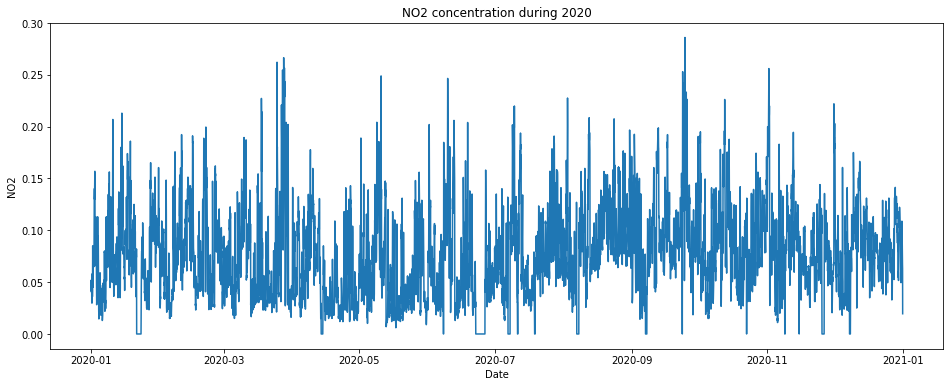

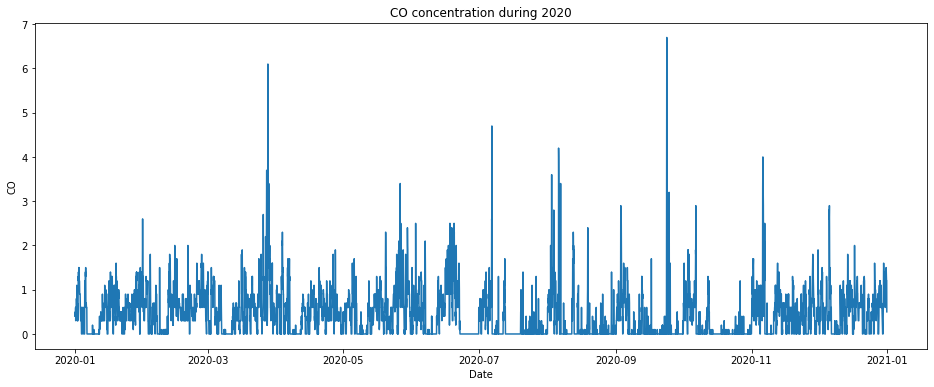

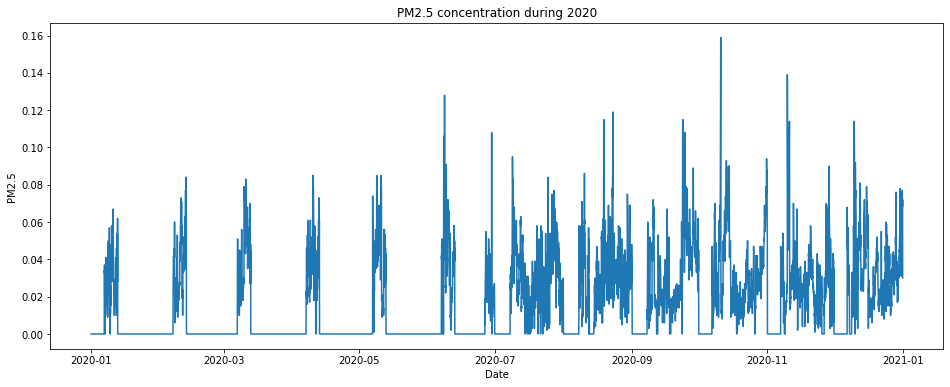

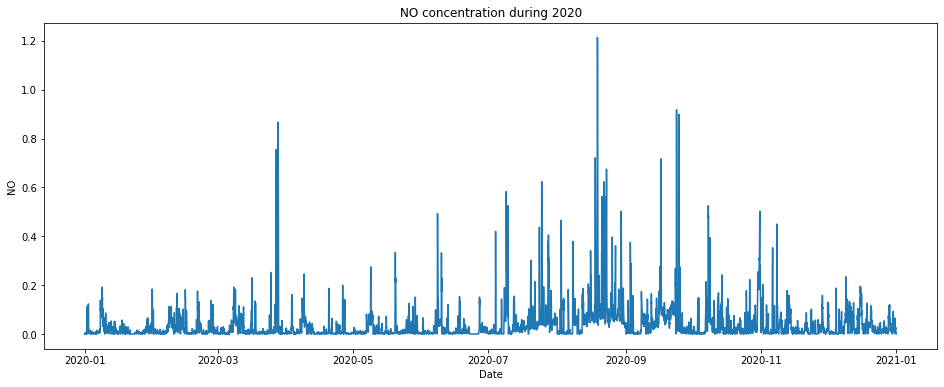

In [ ]:
plot_targets(data_clear)

TRAIN: [   0    1    2 ... 2102 2103 2104] TEST: [2105 2106 2107 ... 4204 4205 4206]
0:	learn: 0.0283864	total: 65.8ms	remaining: 3.23s
1:	learn: 0.0246427	total: 122ms	remaining: 2.93s
2:	learn: 0.0217484	total: 177ms	remaining: 2.78s
3:	learn: 0.0185061	total: 232ms	remaining: 2.67s
4:	learn: 0.0174718	total: 291ms	remaining: 2.62s
5:	learn: 0.0162278	total: 347ms	remaining: 2.54s
6:	learn: 0.0148039	total: 402ms	remaining: 2.47s
7:	learn: 0.0144703	total: 467ms	remaining: 2.45s
8:	learn: 0.0138393	total: 529ms	remaining: 2.41s
9:	learn: 0.0135730	total: 588ms	remaining: 2.35s
10:	learn: 0.0130540	total: 643ms	remaining: 2.28s
11:	learn: 0.0124042	total: 697ms	remaining: 2.21s
12:	learn: 0.0122023	total: 754ms	remaining: 2.15s
13:	learn: 0.0121429	total: 808ms	remaining: 2.08s
14:	learn: 0.0119731	total: 867ms	remaining: 2.02s
15:	learn: 0.0119149	total: 922ms	remaining: 1.96s
16:	learn: 0.0115125	total: 979ms	remaining: 1.9s
17:	learn: 0.0113881	total: 1.03s	remaining: 1.84s
18:	lea

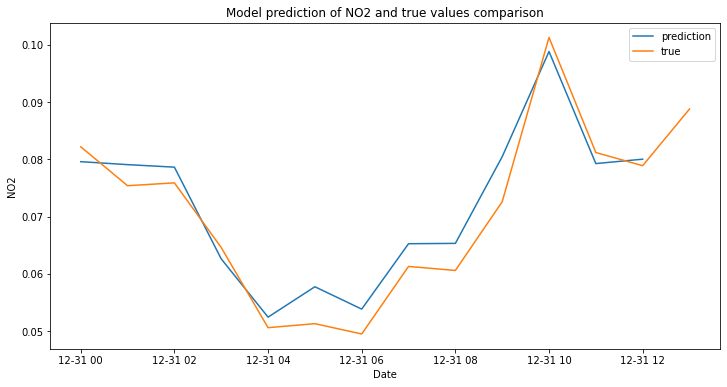

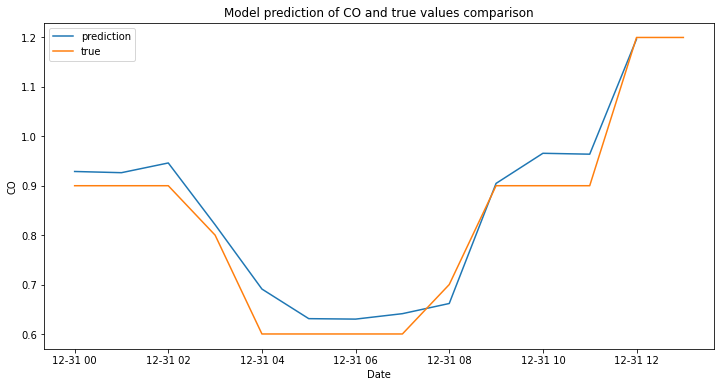

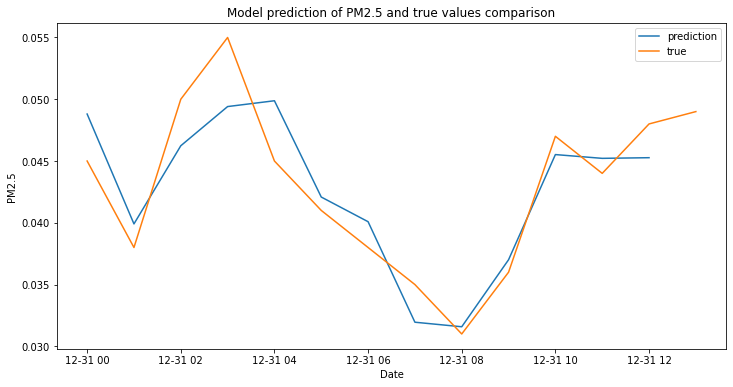

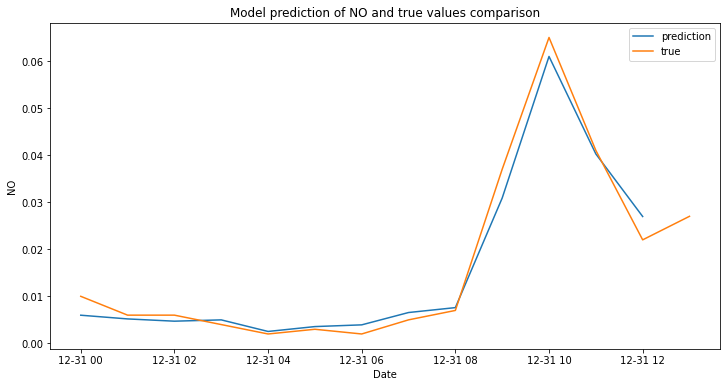

In [ ]:
prediction_anoh = training_and_prediction(data_clear)

In [ ]:
#save predictions into file
prediction_anoh.to_csv('prediction_anoh.csv')

##Koptevskiy Blvd.

In [ ]:
kopt = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Moscow_contest/kopt.csv', decimal=',')
kopt = kopt.set_index('data_time')
kopt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26352 entries, 01/01/2020 00:00:00 to 31/12/2020 23:40:00
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          26352 non-null  int64  
 1   CO                  24686 non-null  object 
 2   NO2                 25162 non-null  object 
 3   NO                  25162 non-null  object 
 4   PM2.5               13142 non-null  object 
 5   Unnamed: 5          0 non-null      float64
 6   Unnamed: 6          0 non-null      float64
 7   -T-                 13321 non-null  object 
 8   | V |               13321 non-null  object 
 9   _V_                 13321 non-null  object 
 10  Давление            13321 non-null  object 
 11  Влажность           13159 non-null  object 
 12  Осадки              13321 non-null  object 
 13  0                   25673 non-null  float64
 14  50                  25673 non-null  float64
 15  100                 25673 

In [ ]:
data_clear = to_numeric(kopt)
data_clear = preprocessing(data_clear)
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Freq: H
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CO                  8784 non-null   float64
 1   NO2                 8784 non-null   float64
 2   NO                  8784 non-null   float64
 3   PM2.5               8784 non-null   float64
 4   -T-                 8784 non-null   float64
 5   | V |               8784 non-null   float64
 6   _V_                 8784 non-null   float64
 7   pressure            8784 non-null   float64
 8   humidity            8784 non-null   float64
 9   precipitation       8784 non-null   float64
 10  0                   8784 non-null   float64
 11  50                  8784 non-null   float64
 12  100                 8784 non-null   float64
 13  150                 8784 non-null   float64
 14  200                 8784 non-null   float64
 15  250        

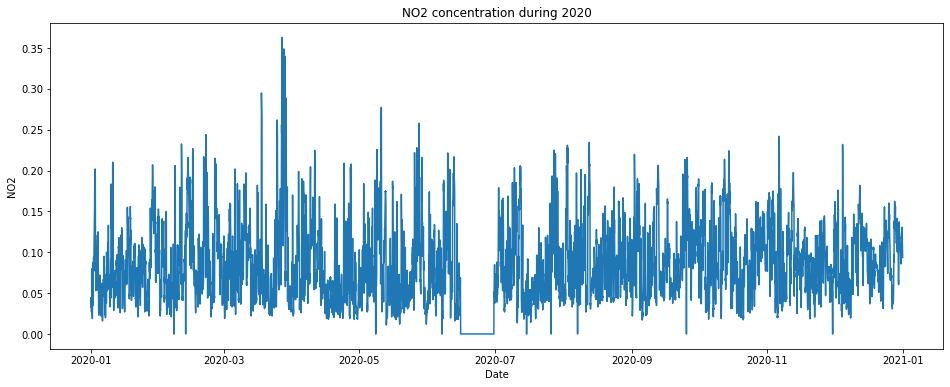

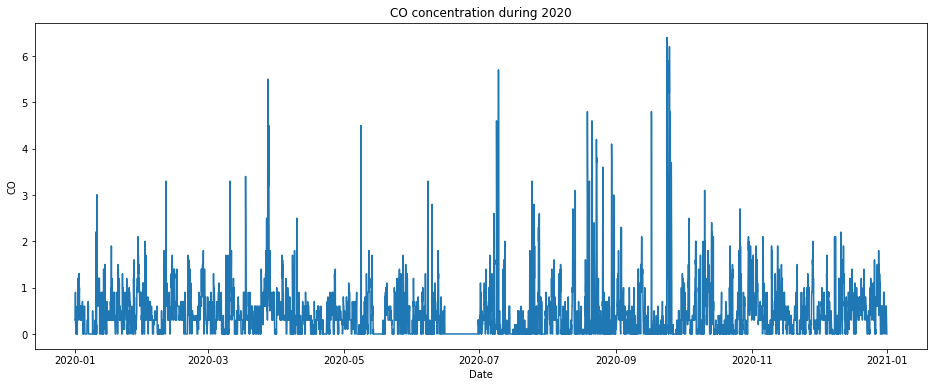

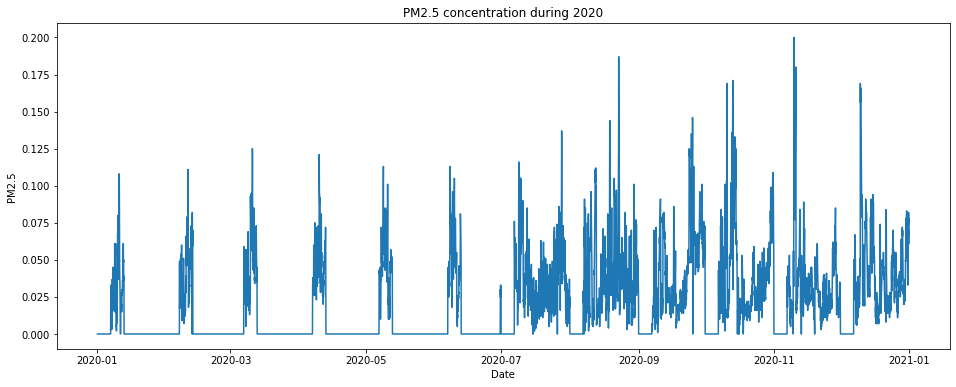

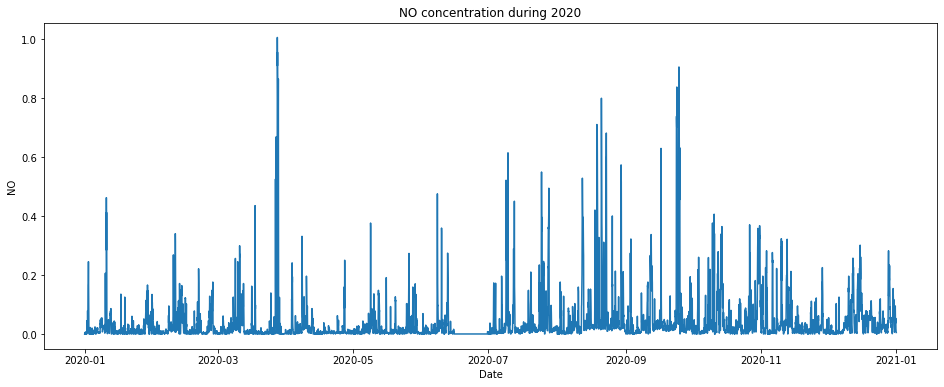

In [ ]:
plot_targets(data_clear)

TRAIN: [   0    1    2 ... 2102 2103 2104] TEST: [2105 2106 2107 ... 4204 4205 4206]
0:	learn: 0.0330801	total: 72.9ms	remaining: 3.57s
1:	learn: 0.0291351	total: 136ms	remaining: 3.27s
2:	learn: 0.0249145	total: 196ms	remaining: 3.07s
3:	learn: 0.0214566	total: 257ms	remaining: 2.96s
4:	learn: 0.0197925	total: 319ms	remaining: 2.87s
5:	learn: 0.0191733	total: 377ms	remaining: 2.77s
6:	learn: 0.0176526	total: 435ms	remaining: 2.67s
7:	learn: 0.0164881	total: 495ms	remaining: 2.6s
8:	learn: 0.0158861	total: 556ms	remaining: 2.53s
9:	learn: 0.0155630	total: 629ms	remaining: 2.51s
10:	learn: 0.0151073	total: 692ms	remaining: 2.45s
11:	learn: 0.0148897	total: 751ms	remaining: 2.38s
12:	learn: 0.0142330	total: 814ms	remaining: 2.31s
13:	learn: 0.0140381	total: 877ms	remaining: 2.25s
14:	learn: 0.0139665	total: 936ms	remaining: 2.18s
15:	learn: 0.0138889	total: 996ms	remaining: 2.12s
16:	learn: 0.0136109	total: 1.06s	remaining: 2.05s
17:	learn: 0.0135265	total: 1.12s	remaining: 1.99s
18:	lea

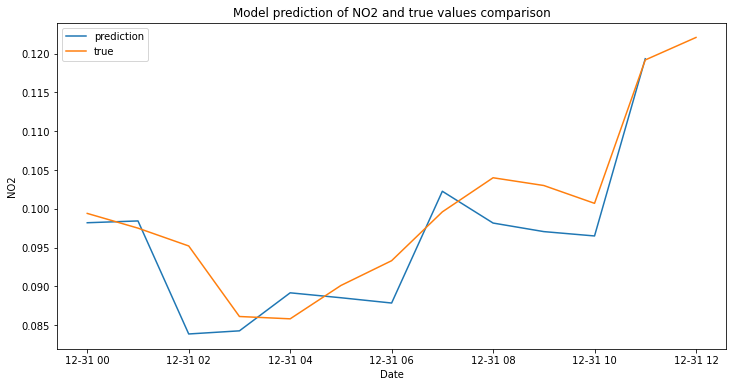

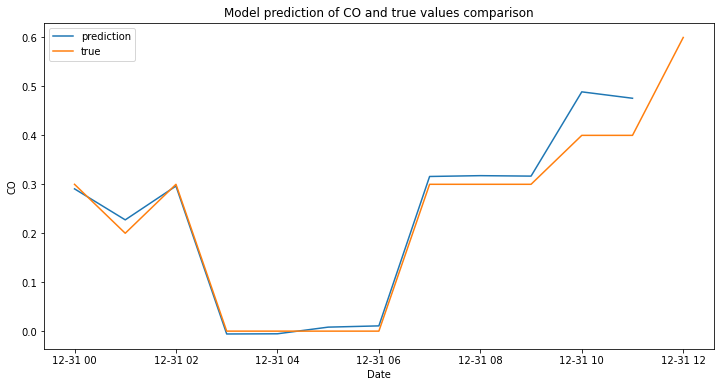

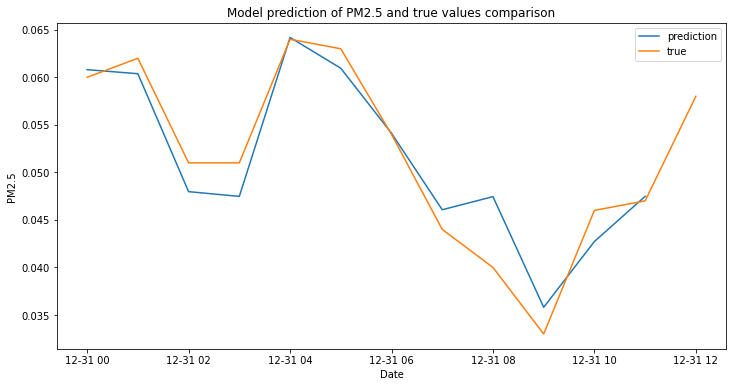

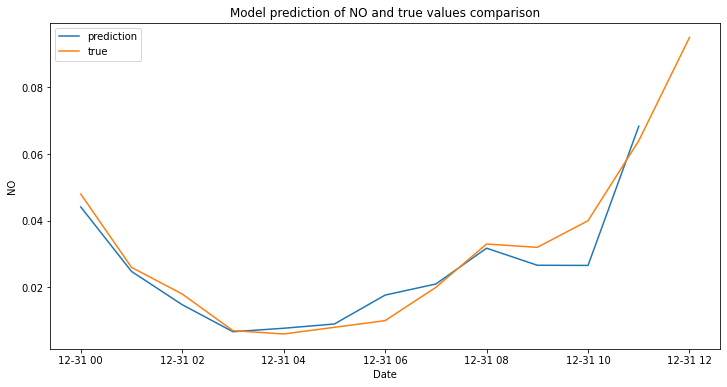

In [ ]:
prediction_kopt = training_and_prediction(data_clear)

In [ ]:
#save predictions into file
prediction_kopt.to_csv('prediction_kopt.csv')

#Conclusion:

We've built models to predict indicators of air quality such as CO, NO2, NO, PM10, PM25 for 9 monitoring station of Moscow for the next day. Mean absolute percentage error most of them is less than 10%. Next step is to put them on the map!